**This notebook is inspired from lot of online resources. Some notebboks that inspired this notebook are:**

*   [guillaume-chevalier's notebook](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition)
*   [Deep Learning activity recognition](https://github.com/takumiw/Deep-Learning-for-Human-Activity-Recognition)
*   [Colah blog](http://colah.github.io/) ⬅️ Actually this helped a lot.

*   [Gaurav Sharma](https://github.com/gauravtheP/Human-Activity-Recognition)





## Plan of Action
* We will apply classical Machine Learning models.
* We will use LSTM on time-series data.

In [ ]:
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI HAR Dataset.zip"
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI HAR Dataset.names"
!unzip '/content/UCI HAR Dataset.zip'
!pip install hyperas hyperopt

--2020-11-02 13:22:10--  https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60999314 (58M) [application/x-httpd-php]
Saving to: ‘UCI HAR Dataset.zip’

UCI HAR Dataset.zip 100%[===================>]  58.17M  33.5MB/s    in 1.7s    

2020-11-02 13:22:12 (33.5 MB/s) - ‘UCI HAR Dataset.zip’ saved [60999314/60999314]

--2020-11-02 13:22:12--  https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6304 (6.2K) [application/x-httpd-php]
Saving to: ‘UCI HAR Dataset.names’

UCI HAR Dataset.nam 100%[====

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import warnings
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

warnings.simplefilter("ignore")

## Extracting Features

In [ ]:
features = list()
with open("/content/UCI HAR Dataset/features.txt") as f:
    for line in f:
        features.append(line.split()[1])


In [ ]:
len(features)

561

## Reading train Data

In [ ]:
# Import the HAR dataset
x_train_file = open('UCI HAR Dataset/train/X_train.txt', 'r')
y_train_file = open('UCI HAR Dataset/train/y_train.txt', 'r')

x_test_file = open('UCI HAR Dataset/test/X_test.txt', 'r')
y_test_file = open('UCI HAR Dataset/test/y_test.txt', 'r')

# Create empty lists
x_train = []
y_train = []
x_test = []
y_test = []



# Loop through datasets
for x in x_train_file:
    x_train.append([float(ts) for ts in x.split()])
    
for y in y_train_file:
    y_train.append(int(y.rstrip('\n')))
    
for x in x_test_file:
    x_test.append([float(ts) for ts in x.split()])
    
for y in y_test_file:
    y_test.append(int(y.rstrip('\n')))
    
# Convert to numpy for efficiency
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

In [ ]:
# train_df = pd.read_csv("/content/UCI HAR Dataset/train/X_train.txt", delim_whitespace = True, names = features)
train_df = pd.DataFrame(x_train,columns=features)
train_df.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-energy(),fBodyBodyAccJerkMag-iqr(),fBodyBodyAccJerkMag-entropy(),fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,-0.567378,-0.744413,0.852947,0.685845,0.814263,-0.965523,-0.999945,-0.999863,-0.994612,-0.994231,-0.987614,-0.943220,-0.407747,-0.679338,-0.602122,0.929294,-0.853011,0.359910,-0.058526,0.256892,-0.224848,0.264106,-0.095246,0.278851,-0.465085,0.491936,-0.190884,0.376314,0.435129,0.660790,...,-0.999918,-0.991364,-1.0,-0.936508,0.346989,-0.516080,-0.802760,-0.980135,-0.961309,-0.973653,-0.952264,-0.989498,-0.980135,-0.999240,-0.992656,-0.701291,-1.000000,-0.128989,0.586156,0.374605,-0.991990,-0.990697,-0.989941,-0.992448,-0.991048,-0.991990,-0.999937,-0.990458,-0.871306,-1.000000,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,-0.557851,-0.818409,0.849308,0.685845,0.822637,-0.981930,-0.999991,-0.999788,-0.998405,-0.999150,-0.977866,-0.948225,-0.714892,-0.500930,-0.570979,0.611627,-0.329549,0.284213,0.284595,0.115705,-0.090963,0.294310,-0.281211,0.085988,-0.022153,-0.016657,-0.220643,-0.013429,-0.072692,0.579382,...,-0.999867,-0.991134,-1.0,-0.841270,0.532061,-0.624871,-0.900160,-0.988296,-0.983322,-0.982659,-0.986321,-0.991829,-0.988296,-0.999811,-0.993979,-0.720683,-0.948718,-0.271958,-0.336310,-0.720015,-0.995854,-0.996399,-0.995442,-0.996866,-0.994440,-0.995854,-0.999981,-0.994544,-1.000000,-1.000000,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,-0.557851,-0.818409,0.843609,0.682401,0.839344,-0.983478,-0.999969,-0.999660,-0.999470,-0.997130,-0.964810,-0.974675,-0.592235,-0.485821,-0.570979,0.273025,-0.086309,0.337202,-0.164739,0.017150,-0.074507,0.342256,-0.332564,0.239281,-0.136204,0.173863,-0.299493,-0.124698,-0.181105,0.608900,...,-0.999845,-0.986658,-1.0,-0.904762,0.660795,-0.724697,-0.928539,-0.989255,-0.986

In [ ]:
subject_trainn = []
subject_train_file = open('UCI HAR Dataset/train/subject_train.txt')
for x in subject_train_file:
    subject_trainn.append([float(ts) for ts in x.split()])


# train_df["subject_id"] = pd.read_csv("/content/UCI HAR Dataset/train/subject_train.txt", header = None, squeeze = True) #squeeze = True will 
# #return data in pandas series format

train_df['subject_id'] = pd.DataFrame(np.array(subject_trainn))

train_df["activity"] = pd.DataFrame(y_train)

activity = pd.Series(y_train)

#mapping activity to activity name
label_name = activity.map({1: "WALKING", 2:"WALKING_UPSTAIRS", 3:"WALKING_DOWNSTAIRS", 4:"SITTING", 5:"STANDING", 6:"LYING"})

train_df["activity_name"] = label_name

train_df.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject_id,activity,activity_name
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,-0.567378,-0.744413,0.852947,0.685845,0.814263,-0.965523,-0.999945,-0.999863,-0.994612,-0.994231,-0.987614,-0.943220,-0.407747,-0.679338,-0.602122,0.929294,-0.853011,0.359910,-0.058526,0.256892,-0.224848,0.264106,-0.095246,0.278851,-0.465085,0.491936,-0.190884,0.376314,0.435129,0.660790,...,-0.936508,0.346989,-0.516080,-0.802760,-0.980135,-0.961309,-0.973653,-0.952264,-0.989498,-0.980135,-0.999240,-0.992656,-0.701291,-1.000000,-0.128989,0.586156,0.374605,-0.991990,-0.990697,-0.989941,-0.992448,-0.991048,-0.991990,-0.999937,-0.990458,-0.871306,-1.000000,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1.0,5,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,-0.557851,-0.818409,0.849308,0.685845,0.822637,-0.981930,-0.999991,-0.999788,-0.998405,-0.999150,-0.977866,-0.948225,-0.714892,-0.500930,-0.570979,0.611627,-0.329549,0.284213,0.284595,0.115705,-0.090963,0.294310,-0.281211,0.085988,-0.022153,-0.016657,-0.220643,-0.013429,-0.072692,0.579382,...,-0.841270,0.532061,-0.624871,-0.900160,-0.988296,-0.983322,-0.982659,-0.986321,-0.991829,-0.988296,-0.999811,-0.993979,-0.720683,-0.948718,-0.271958,-0.336310,-0.720015,-0.995854,-0.996399,-0.995442,-0.996866,-0.994440,-0.995854,-0.999981,-0.994544,-1.000000,-1.000000,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1.0,5,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,-0.557851,-0.818409,0.843609,0.682401,0.839344,-0.983478,-0.999969,-0.999660,-0.999470,-0.997130,-0.964810,-0.974675,-0.592235,-0.485821,-0.570979,0.273025,-0.086309,0.337202,-0.164739,0.017150,-0.074507,0.342256,-0.332564,0.239281,-0.136204,0.173863,-0.299493,-0.124698,-0.181105,0.608900,...,-0.904762,0.660795,-0.724697,-0.928539,-0.989255,-0.986028,-0.984274,-0.990979,-0.995703,-0.989255,-0.999854,-0.993238,-0.736521,-0.794872,-0.212728,-0

In [ ]:
print("Size of Train data = {}".format(train_df.shape))

Size of Train data = (7352, 564)


## 1. Reading Test Data

In [ ]:
test_df = pd.DataFrame(x_test,columns=features)

subject_testt = []
subject_test_file = open('UCI HAR Dataset/test/subject_test.txt')
for x in subject_test_file:
    subject_testt.append([float(ts) for ts in x.split()])


test_df["subject_id"] = pd.DataFrame(subject_testt)

test_df["activity"] = pd.DataFrame(y_test)

activity = pd.Series(y_test)

#mapping activity to activity name
label_name = activity.map({1: "WALKING", 2:"WALKING_UPSTAIRS", 3:"WALKING_DOWNSTAIRS", 4:"SITTING", 5:"STANDING", 6:"LYING"})

test_df["activity_name"] = label_name

test_df.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",...,fBodyBodyAccJerkMag-maxInds,fBodyBodyAccJerkMag-meanFreq(),fBodyBodyAccJerkMag-skewness(),fBodyBodyAccJerkMag-kurtosis(),fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-std(),fBodyBodyGyroMag-mad(),fBodyBodyGyroMag-max(),fBodyBodyGyroMag-min(),fBodyBodyGyroMag-sma(),fBodyBodyGyroMag-energy(),fBodyBodyGyroMag-iqr(),fBodyBodyGyroMag-entropy(),fBodyBodyGyroMag-maxInds,fBodyBodyGyroMag-meanFreq(),fBodyBodyGyroMag-skewness(),fBodyBodyGyroMag-kurtosis(),fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-std(),fBodyBodyGyroJerkMag-mad(),fBodyBodyGyroJerkMag-max(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-sma(),fBodyBodyGyroJerkMag-energy(),fBodyBodyGyroJerkMag-iqr(),fBodyBodyGyroJerkMag-entropy(),fBodyBodyGyroJerkMag-maxInds,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject_id,activity,activity_name
0,0.257178,-0.023285,-0.014654,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,-0.674302,-0.894088,-0.554577,-0.466223,0.717208,0.635502,0.789497,-0.877764,-0.997766,-0.998414,-0.934345,-0.975669,-0.949824,-0.830478,-0.168084,-0.378996,0.246217,0.521204,-0.487793,0.482280,-0.045462,0.211955,-0.134894,0.130858,-0.014176,-0.105971,0.073544,-0.171516,0.040063,0.076989,-0.490546,-0.709003,...,-1.000000,-0.035356,-0.254248,-0.700326,-0.770610,-0.797113,-0.764485,-0.820188,-0.937959,-0.770610,-0.970958,-0.798387,0.179435,-1.000000,-0.047391,-0.467849,-0.761326,-0.890165,-0.907308,-0.895301,-0.917883,-0.909829,-0.890165,-0.994105,-0.898022,-0.234815,-1.000000,0.071645,-0.330370,-0.705974,0.006462,0.162920,-0.825886,0.271151,-0.720009,0.276801,-0.057978,2.0,5,STANDING
1,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,-0.554577,-0.806013,0.768031,0.683698,0.796706,-0.969097,-0.999580,-0.999646,-0.997720,-0.994006,-0.973637,-0.950720,-0.302437,-0.348243,-0.404785,0.507492,-0.156495,0.040674,0.272991,0.197566,-0.194556,0.411411,-0.340466,0.077555,-0.084024,0.035305,-0.010083,-0.104983,-0.429134,0.399177,...,-1.000000,-0.491213,-0.215404,-0.666004,-0.924461,-0.916774,-0.919383,-0.917983,-0.991121,-0.924461,-0.995727,-0.933127,-0.218860,-1.000000,-0.031474,-0.090655,-0.461801,-0.951977,-0.938212,-0.938008,-0.949922,-0.986902,-0.951977,-0.998272,-0.951255,-0.431053,-1.000000,-0.401189,-0.121845,-0.594944,-0.083495,0.017500,-0.434375,0.920593,-0.698091,0.281343,-0.083898,2.0,5,STANDING
2,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,-0.963483,-0.939260,-0.568512,-0.799116,0.848305,0.667864,0.822442,-0.976782,-0.999954,-0.999570,-0.998720,-0.993456,-0.974266,-0.964976,-0.617916,-0.695490,-0.536693,0.242147,-0.114997,0.032703,0.192385,-0.011945,-0.063363,0.470819,-0.507395,0.188536,-0.231575,0.632120,-0.550708,0.305653,-0.323848,0.279786,...,-1.000000,0.140729,-0.206062,-0.639809,-0.975209,-0.973998,-0.967097,-0.982849,-0.997663,-0.975209,-0.999504,-0.968260,-0.561266,-0.897436,-0.168805,-0

In [ ]:
print("Size of Test data = {}".format(test_df.shape))

Size of Test data = (2947, 564)


## 2. Data Cleaning

In [ ]:
# Checking for nan values
print("Number of NaN values in train data is "+str(train_df.isnull().sum().sum()))
print("Number of NaN values in test data is "+str(test_df.isnull().sum().sum()))

Number of NaN values in train data is 0
Number of NaN values in test data is 0


In [ ]:
# Checking for duplicate values
print("Number of duplicate values in train data is "+str(sum(train_df.duplicated())))
print("Number of duplicate values in test data is "+str(sum(test_df.duplicated())))

Number of duplicate values in train data is 0
Number of duplicate values in test data is 0


## 3. Checking for imbalance in data

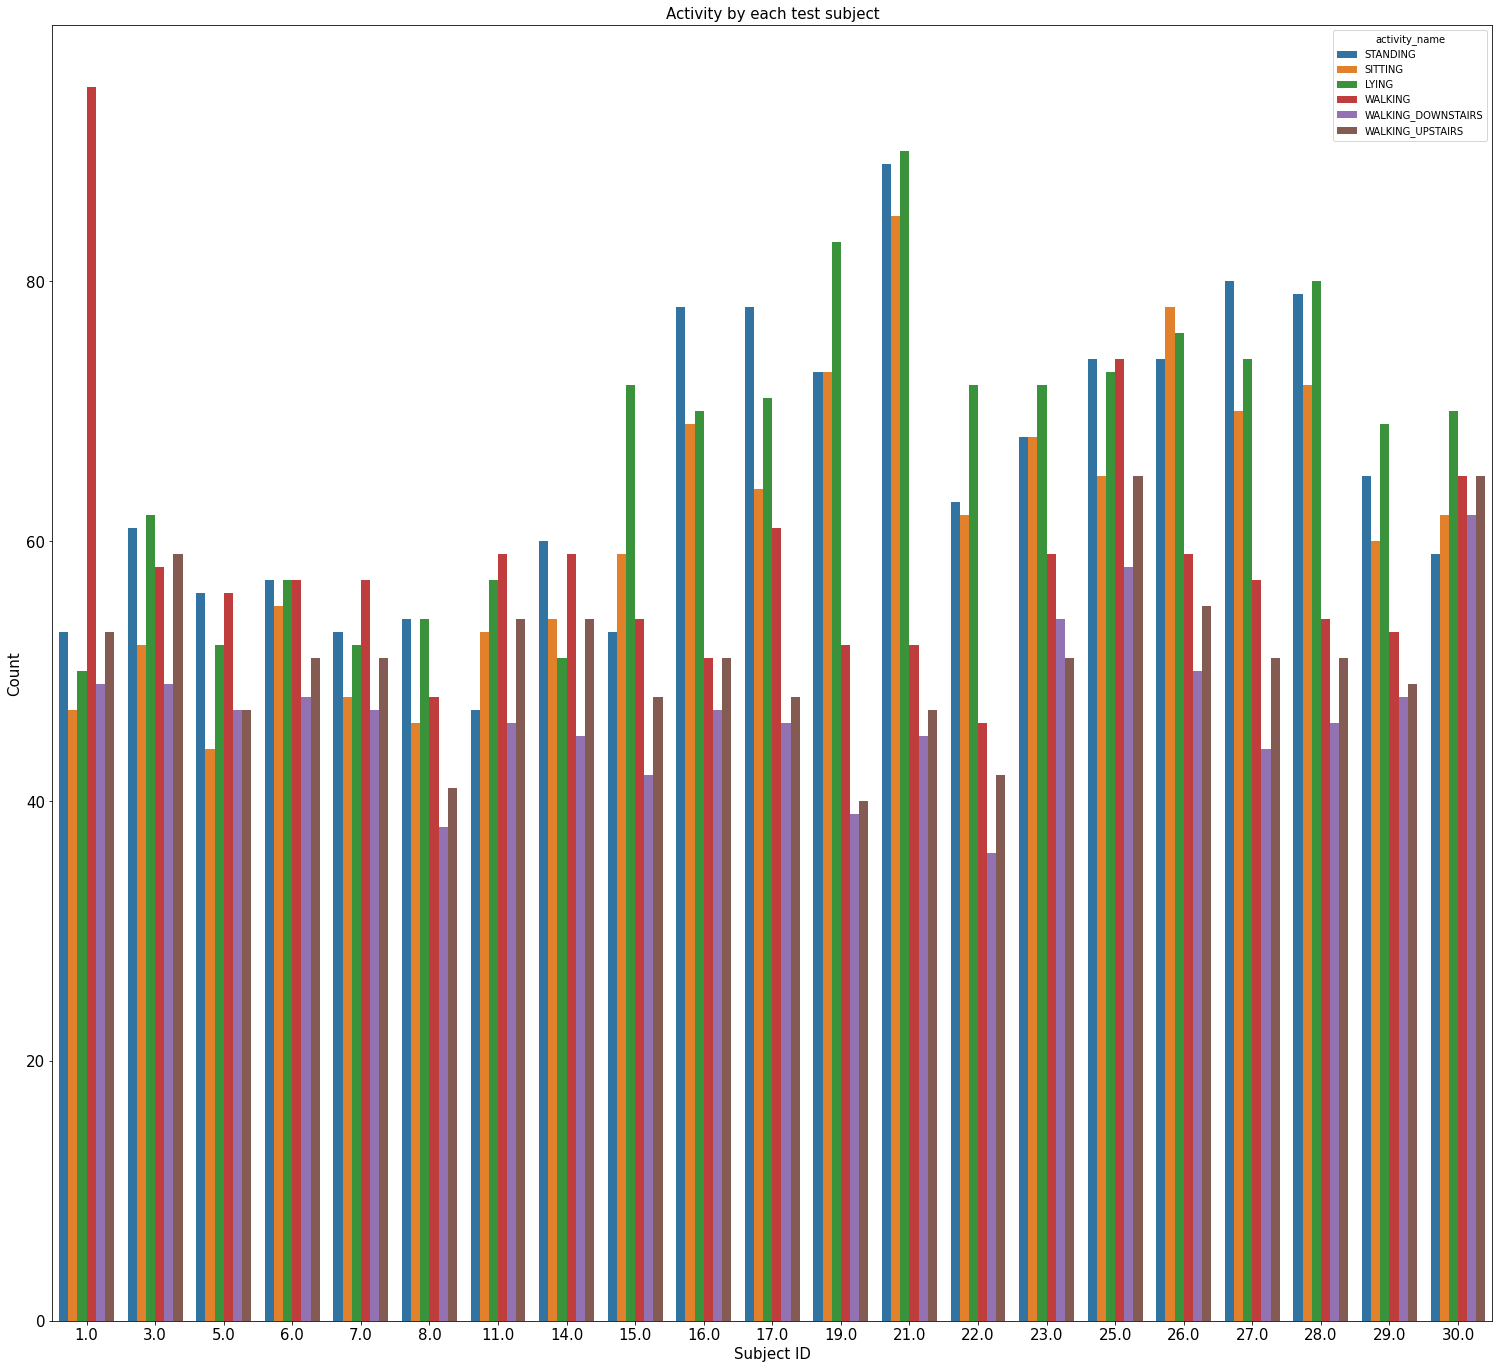

In [ ]:
fig = plt.figure(figsize = (20, 18))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Activity by each test subject", fontsize = 15)
plt.tick_params(labelsize = 15)
sns.countplot(x = "subject_id", hue = "activity_name", data = train_df)
plt.xlabel("Subject ID", fontsize = 15)
plt.ylabel("Count", fontsize = 15)
plt.show()

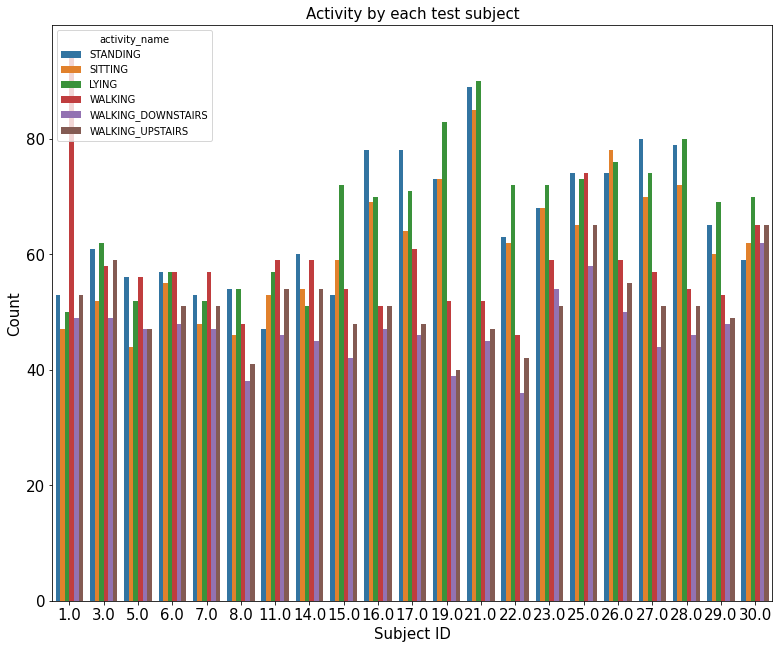

In [ ]:
fig = plt.figure(figsize = (10, 8))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Activity by each test subject", fontsize = 15)
plt.tick_params(labelsize = 15)
sns.countplot(x = "subject_id", hue = "activity_name", data = train_df)
plt.xlabel("Subject ID", fontsize = 15)
plt.ylabel("Count", fontsize = 15)
plt.show()

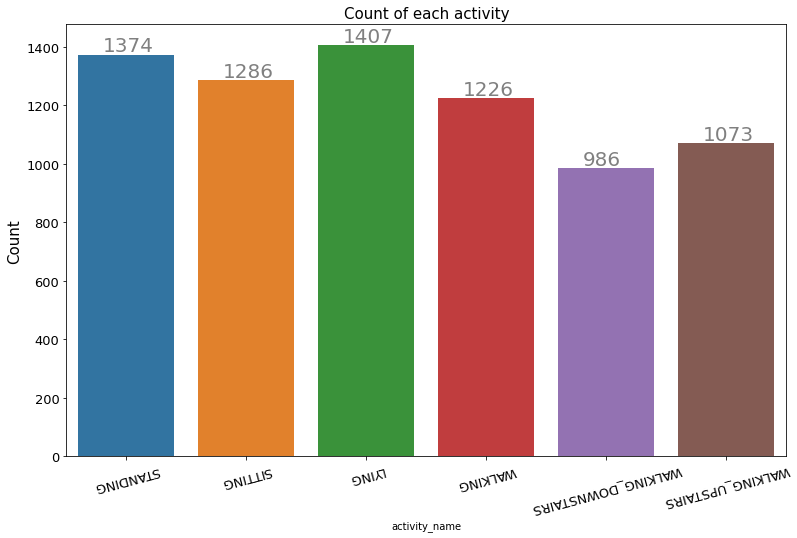

In [ ]:
fig = plt.figure(figsize = (10, 6))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Count of each activity", fontsize = 15)
plt.tick_params(labelsize = 10)
sns.countplot(x = "activity_name", data = train_df)
for i in ax.patches:
    ax.text(x = i.get_x() + 0.2, y = i.get_height()+10, s = str(i.get_height()), fontsize = 20, color = "grey")
plt.ylabel("Count", fontsize = 15)
plt.tick_params(labelsize = 13)
plt.xticks(rotation = 195)
plt.show()

<b>Observation</b><br>
From the above two plots, we can infer that our classes are almost balanced.

## 4. Changing Feature Name

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

In [ ]:
columns = train_df.columns

In [ ]:
columns = columns.str.replace("[()]", '') 
columns = columns.str.replace("-", '')
columns = columns.str.replace(",", '')

train_df.columns = columns
test_df.columns = columns

In [ ]:
train_df.columns

Index(['tBodyAccmeanX', 'tBodyAccmeanY', 'tBodyAccmeanZ', 'tBodyAccstdX',
       'tBodyAccstdY', 'tBodyAccstdZ', 'tBodyAccmadX', 'tBodyAccmadY',
       'tBodyAccmadZ', 'tBodyAccmaxX',
       ...
       'angletBodyAccMeangravity', 'angletBodyAccJerkMeangravityMean',
       'angletBodyGyroMeangravityMean', 'angletBodyGyroJerkMeangravityMean',
       'angleXgravityMean', 'angleYgravityMean', 'angleZgravityMean',
       'subject_id', 'activity', 'activity_name'],
      dtype='object', length=564)

In [ ]:
train_df.head()

,tBodyAccmeanX,tBodyAccmeanY,tBodyAccmeanZ,tBodyAccstdX,tBodyAccstdY,tBodyAccstdZ,tBodyAccmadX,tBodyAccmadY,tBodyAccmadZ,tBodyAccmaxX,tBodyAccmaxY,tBodyAccmaxZ,tBodyAccminX,tBodyAccminY,tBodyAccminZ,tBodyAccsma,tBodyAccenergyX,tBodyAccenergyY,tBodyAccenergyZ,tBodyAcciqrX,tBodyAcciqrY,tBodyAcciqrZ,tBodyAccentropyX,tBodyAccentropyY,tBodyAccentropyZ,tBodyAccarCoeffX1,tBodyAccarCoeffX2,tBodyAccarCoeffX3,tBodyAccarCoeffX4,tBodyAccarCoeffY1,tBodyAccarCoeffY2,tBodyAccarCoeffY3,tBodyAccarCoeffY4,tBodyAccarCoeffZ1,tBodyAccarCoeffZ2,tBodyAccarCoeffZ3,tBodyAccarCoeffZ4,tBodyAcccorrelationXY,tBodyAcccorrelationXZ,tBodyAcccorrelationYZ,...,fBodyBodyAccJerkMagmaxInds,fBodyBodyAccJerkMagmeanFreq,fBodyBodyAccJerkMagskewness,fBodyBodyAccJerkMagkurtosis,fBodyBodyGyroMagmean,fBodyBodyGyroMagstd,fBodyBodyGyroMagmad,fBodyBodyGyroMagmax,fBodyBodyGyroMagmin,fBodyBodyGyroMagsma,fBodyBodyGyroMagenergy,fBodyBodyGyroMagiqr,fBodyBodyGyroMagentropy,fBodyBodyGyroMagmaxInds,fBodyBodyGyroMagmeanFreq,fBodyBodyGyroMagskewness,fBodyBodyGyroMagkurtosis,fBodyBodyGyroJerkMagmean,fBodyBodyGyroJerkMagstd,fBodyBodyGyroJerkMagmad,fBodyBodyGyroJerkMagmax,fBodyBodyGyroJerkMagmin,fBodyBodyGyroJerkMagsma,fBodyBodyGyroJerkMagenergy,fBodyBodyGyroJerkMagiqr,fBodyBodyGyroJerkMagentropy,fBodyBodyGyroJerkMagmaxInds,fBodyBodyGyroJerkMagmeanFreq,fBodyBodyGyroJerkMagskewness,fBodyBodyGyroJerkMagkurtosis,angletBodyAccMeangravity,angletBodyAccJerkMeangravityMean,angletBodyGyroMeangravityMean,angletBodyGyroJerkMeangravityMean,angleXgravityMean,angleYgravityMean,angleZgravityMean,subject_id,activity,activity_name
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,-0.567378,-0.744413,0.852947,0.685845,0.814263,-0.965523,-0.999945,-0.999863,-0.994612,-0.994231,-0.987614,-0.943220,-0.407747,-0.679338,-0.602122,0.929294,-0.853011,0.359910,-0.058526,0.256892,-0.224848,0.264106,-0.095246,0.278851,-0.465085,0.491936,-0.190884,0.376314,0.435129,0.660790,...,-0.936508,0.346989,-0.516080,-0.802760,-0.980135,-0.961309,-0.973653,-0.952264,-0.989498,-0.980135,-0.999240,-0.992656,-0.701291,-1.000000,-0.128989,0.586156,0.374605,-0.991990,-0.990697,-0.989941,-0.992448,-0.991048,-0.991990,-0.999937,-0.990458,-0.871306,-1.000000,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1.0,5,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,-0.557851,-0.818409,0.849308,0.685845,0.822637,-0.981930,-0.999991,-0.999788,-0.998405,-0.999150,-0.977866,-0.948225,-0.714892,-0.500930,-0.570979,0.611627,-0.329549,0.284213,0.284595,0.115705,-0.090963,0.294310,-0.281211,0.085988,-0.022153,-0.016657,-0.220643,-0.013429,-0.072692,0.579382,...,-0.841270,0.532061,-0.624871,-0.900160,-0.988296,-0.983322,-0.982659,-0.986321,-0.991829,-0.988296,-0.999811,-0.993979,-0.720683,-0.948718,-0.271958,-0.336310,-0.720015,-0.995854,-0.996399,-0.995442,-0.996866,-0.994440,-0.995854,-0.999981,-0.994544,-1.000000,-1.000000,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1.0,5,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,-0.557851,-0.818409,0.843609,0.682401,0.839344,-0.983478,-0.999969,-0.999660,-0.999470,-0.997130,-0.964810,-0.974675,-0.592235,-0.485821,-0.570979,0.273025,-0.086309,0.337202,-0.164739,0.017150,-0.074507,0.342256,-0.332564,0.239281,-0.136204,0.173863,-0.299493,-0.124698,-0.181105,0.608900,...,-0.904762,0.660795,-0.724697,-0.928539,-0.989255,-0.986028,-0.984274,-0.990979,-0.995703,-0.989255,-0.999854,-0.993238,-0.736521,-0.794872,-0.212728,-0.535352,-0.871914,-0.995031,-0.995127,-0.994640,-0.996060,-0.995866,-0.995031,-0.999973,-0.993755,-1.000000,-0.555556,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1.0,5,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.93

In [ ]:
test_df.head()

,tBodyAccmeanX,tBodyAccmeanY,tBodyAccmeanZ,tBodyAccstdX,tBodyAccstdY,tBodyAccstdZ,tBodyAccmadX,tBodyAccmadY,tBodyAccmadZ,tBodyAccmaxX,tBodyAccmaxY,tBodyAccmaxZ,tBodyAccminX,tBodyAccminY,tBodyAccminZ,tBodyAccsma,tBodyAccenergyX,tBodyAccenergyY,tBodyAccenergyZ,tBodyAcciqrX,tBodyAcciqrY,tBodyAcciqrZ,tBodyAccentropyX,tBodyAccentropyY,tBodyAccentropyZ,tBodyAccarCoeffX1,tBodyAccarCoeffX2,tBodyAccarCoeffX3,tBodyAccarCoeffX4,tBodyAccarCoeffY1,tBodyAccarCoeffY2,tBodyAccarCoeffY3,tBodyAccarCoeffY4,tBodyAccarCoeffZ1,tBodyAccarCoeffZ2,tBodyAccarCoeffZ3,tBodyAccarCoeffZ4,tBodyAcccorrelationXY,tBodyAcccorrelationXZ,tBodyAcccorrelationYZ,...,fBodyBodyAccJerkMagmaxInds,fBodyBodyAccJerkMagmeanFreq,fBodyBodyAccJerkMagskewness,fBodyBodyAccJerkMagkurtosis,fBodyBodyGyroMagmean,fBodyBodyGyroMagstd,fBodyBodyGyroMagmad,fBodyBodyGyroMagmax,fBodyBodyGyroMagmin,fBodyBodyGyroMagsma,fBodyBodyGyroMagenergy,fBodyBodyGyroMagiqr,fBodyBodyGyroMagentropy,fBodyBodyGyroMagmaxInds,fBodyBodyGyroMagmeanFreq,fBodyBodyGyroMagskewness,fBodyBodyGyroMagkurtosis,fBodyBodyGyroJerkMagmean,fBodyBodyGyroJerkMagstd,fBodyBodyGyroJerkMagmad,fBodyBodyGyroJerkMagmax,fBodyBodyGyroJerkMagmin,fBodyBodyGyroJerkMagsma,fBodyBodyGyroJerkMagenergy,fBodyBodyGyroJerkMagiqr,fBodyBodyGyroJerkMagentropy,fBodyBodyGyroJerkMagmaxInds,fBodyBodyGyroJerkMagmeanFreq,fBodyBodyGyroJerkMagskewness,fBodyBodyGyroJerkMagkurtosis,angletBodyAccMeangravity,angletBodyAccJerkMeangravityMean,angletBodyGyroMeangravityMean,angletBodyGyroJerkMeangravityMean,angleXgravityMean,angleYgravityMean,angleZgravityMean,subject_id,activity,activity_name
0,0.257178,-0.023285,-0.014654,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,-0.674302,-0.894088,-0.554577,-0.466223,0.717208,0.635502,0.789497,-0.877764,-0.997766,-0.998414,-0.934345,-0.975669,-0.949824,-0.830478,-0.168084,-0.378996,0.246217,0.521204,-0.487793,0.482280,-0.045462,0.211955,-0.134894,0.130858,-0.014176,-0.105971,0.073544,-0.171516,0.040063,0.076989,-0.490546,-0.709003,...,-1.000000,-0.035356,-0.254248,-0.700326,-0.770610,-0.797113,-0.764485,-0.820188,-0.937959,-0.770610,-0.970958,-0.798387,0.179435,-1.000000,-0.047391,-0.467849,-0.761326,-0.890165,-0.907308,-0.895301,-0.917883,-0.909829,-0.890165,-0.994105,-0.898022,-0.234815,-1.000000,0.071645,-0.330370,-0.705974,0.006462,0.162920,-0.825886,0.271151,-0.720009,0.276801,-0.057978,2.0,5,STANDING
1,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,-0.554577,-0.806013,0.768031,0.683698,0.796706,-0.969097,-0.999580,-0.999646,-0.997720,-0.994006,-0.973637,-0.950720,-0.302437,-0.348243,-0.404785,0.507492,-0.156495,0.040674,0.272991,0.197566,-0.194556,0.411411,-0.340466,0.077555,-0.084024,0.035305,-0.010083,-0.104983,-0.429134,0.399177,...,-1.000000,-0.491213,-0.215404,-0.666004,-0.924461,-0.916774,-0.919383,-0.917983,-0.991121,-0.924461,-0.995727,-0.933127,-0.218860,-1.000000,-0.031474,-0.090655,-0.461801,-0.951977,-0.938212,-0.938008,-0.949922,-0.986902,-0.951977,-0.998272,-0.951255,-0.431053,-1.000000,-0.401189,-0.121845,-0.594944,-0.083495,0.017500,-0.434375,0.920593,-0.698091,0.281343,-0.083898,2.0,5,STANDING
2,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,-0.963483,-0.939260,-0.568512,-0.799116,0.848305,0.667864,0.822442,-0.976782,-0.999954,-0.999570,-0.998720,-0.993456,-0.974266,-0.964976,-0.617916,-0.695490,-0.536693,0.242147,-0.114997,0.032703,0.192385,-0.011945,-0.063363,0.470819,-0.507395,0.188536,-0.231575,0.632120,-0.550708,0.305653,-0.323848,0.279786,...,-1.000000,0.140729,-0.206062,-0.639809,-0.975209,-0.973998,-0.967097,-0.982849,-0.997663,-0.975209,-0.999504,-0.968260,-0.561266,-0.897436,-0.168805,-0.662317,-0.925364,-0.985689,-0.983273,-0.983422,-0.986857,-0.989609,-0.985689,-0.999831,-0.986148,-0.809976,-0.936508,0.062891,-0.190422,-0.640736,-0.034956,0.202302,0.064103,0.145068,-0.702771,0.280083,-0.079346,2.0,5,STANDING
3,0.270298,-0.032614,-0.117520,-0.994743,-0.973268,-0.967091,-0.995274,-0.974471,-0.968897,-0.93

## 6. Exploratory Data Analysis

<b>Feature information from domain knowledge</b>
1. <b>Static:</b> We have three types static features where test subject is in rest:
    * Sitting
    * Standing
    * Lying
2. <b>Dynamic:</b> We have three types of dynamic features where test subject is in motion:
    * Walking
    * Walking_Downstairs
    * Walking_Upstairs

### Magnitude of Body Accelerator Mean Matters

In [ ]:
plt.rcParams['figure.figsize'] = (18,19)

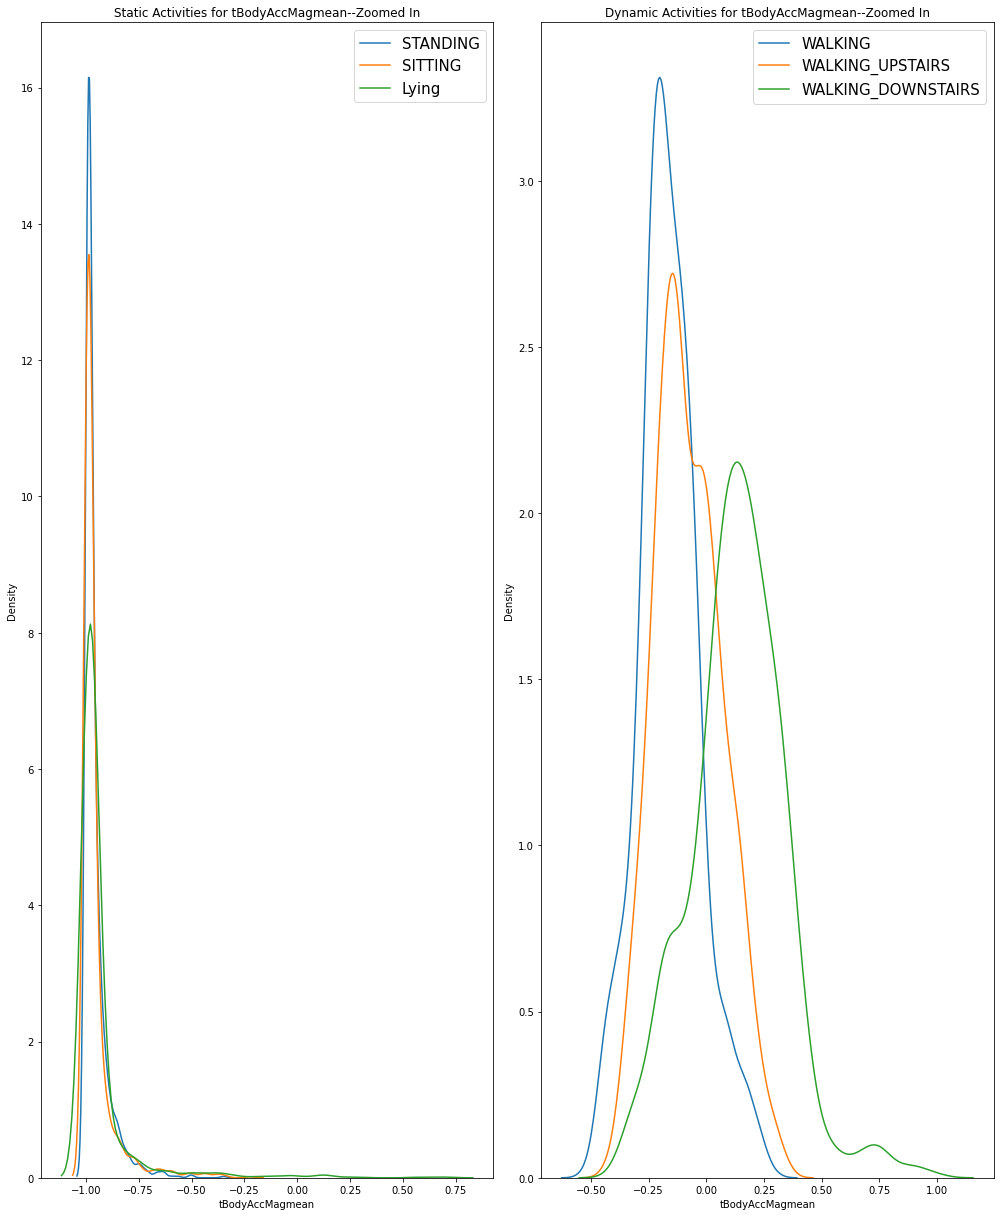

In [ ]:
#let's plot "tBodyAccMagmean" for both static and dynamic activites separately to analysis them in more detail
df_standing = train_df[train_df["activity_name"] == "STANDING"]
df_sitting = train_df[train_df["activity_name"] == "SITTING"]
df_lying = train_df[train_df["activity_name"] == "LYING"]
df_walking = train_df[train_df["activity_name"] == "WALKING"]
df_walking_upstairs = train_df[train_df["activity_name"] == "WALKING_UPSTAIRS"]
df_walking_downstairs = train_df[train_df["activity_name"] == "WALKING_DOWNSTAIRS"]

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 17))

axes[0].set_title("Static Activities for tBodyAccMagmean--Zoomed In")
sns.distplot(df_standing["tBodyAccMagmean"], hist = False, label = "STANDING", ax = axes[0])
sns.distplot(df_sitting["tBodyAccMagmean"], hist = False, label = "SITTING", ax = axes[0])
sns.distplot(df_lying["tBodyAccMagmean"], hist = False, label = "Lying", ax = axes[0])
axes[0].legend(fontsize = 15)


axes[1].set_title("Dynamic Activities for tBodyAccMagmean--Zoomed In")
sns.distplot(df_walking["tBodyAccMagmean"], hist = False, label = "WALKING", ax = axes[1])
sns.distplot(df_walking_upstairs["tBodyAccMagmean"], hist = False, label = "WALKING_UPSTAIRS", ax = axes[1])
sns.distplot(df_walking_downstairs["tBodyAccMagmean"], hist = False, label = "WALKING_DOWNSTAIRS", ax = axes[1])
axes[1].legend(fontsize = 15)


plt.tight_layout()
plt.show()

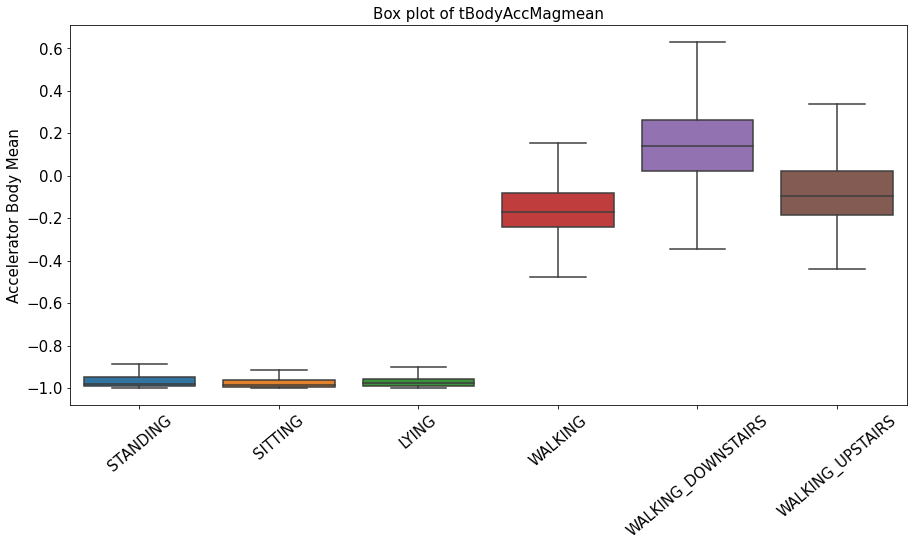

In [ ]:
plt.figure(figsize = (15, 7))
sns.boxplot(x = "activity_name", y = "tBodyAccMagmean", showfliers = False, data = train_df)
plt.title("Box plot of tBodyAccMagmean", fontsize = 15)
plt.ylabel("Accelerator Body Mean", fontsize = 15)
plt.xlabel("Activity Name", fontsize = 15)
plt.xlabel("")
plt.tick_params(labelsize = 15)
plt.xticks(rotation = 40)
plt.show()

## 7. Applying T-SNE on Data

**t-distributed stochastic neighbor embedding**

t-distributed stochastic neighbor embedding is a machine learning algorithm for visualization based on Stochastic Neighbor Embedding

Perplexity is the only free parameter in t-SNE that may need some tweaking. The best way to think of it is as controlling the size of the neighborhood around each point that the embedding attempts to preserve

In [ ]:
def plt_tsne(perplexity, train_df):
    print('*******/*/*/*/**********  DONE BY MAHESH */*/*//////////*/*/************')
    data = train_df.drop(["subject_id", "activity", "activity_name"], axis = 1)
    data_label = train_df["activity_name"]
    applying_tsne = TSNE(n_components = 2, perplexity = perplexity, n_iter = 1000, verbose = 0)
    reduced_dim = applying_tsne.fit_transform(data)
    d = {'Dimension_1': applying_tsne.embedding_[:,0], 'Dimension_2': applying_tsne.embedding_[:,1], "activities":data_label}
    df = pd.DataFrame(data = d)
    print("Done...")
    print("Plotting TSNE Visualization...")
    sns.set_style('whitegrid') 
    sns.lmplot("Dimension_1", "Dimension_2", df, hue = 'activities', markers=['|','>','_', "o", "<", "^"], fit_reg = False, size = 10, scatter_kws={'s':100})
    plt.title("TSNE Plot for Perplexity "+str(perplexity))
    plt.show()

*******/*/*/*/**********  DONE BY MAHESH */*/*//////////*/*/************
Done...
Plotting TSNE Visualization...


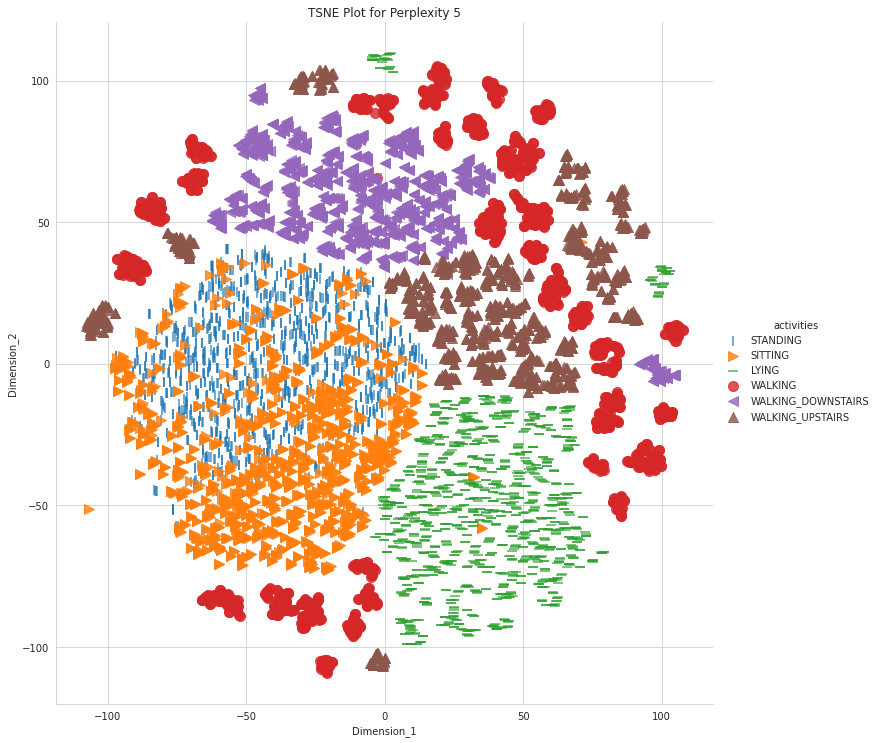

*******/*/*/*/**********  DONE BY MAHESH */*/*//////////*/*/************
Done...
Plotting TSNE Visualization...


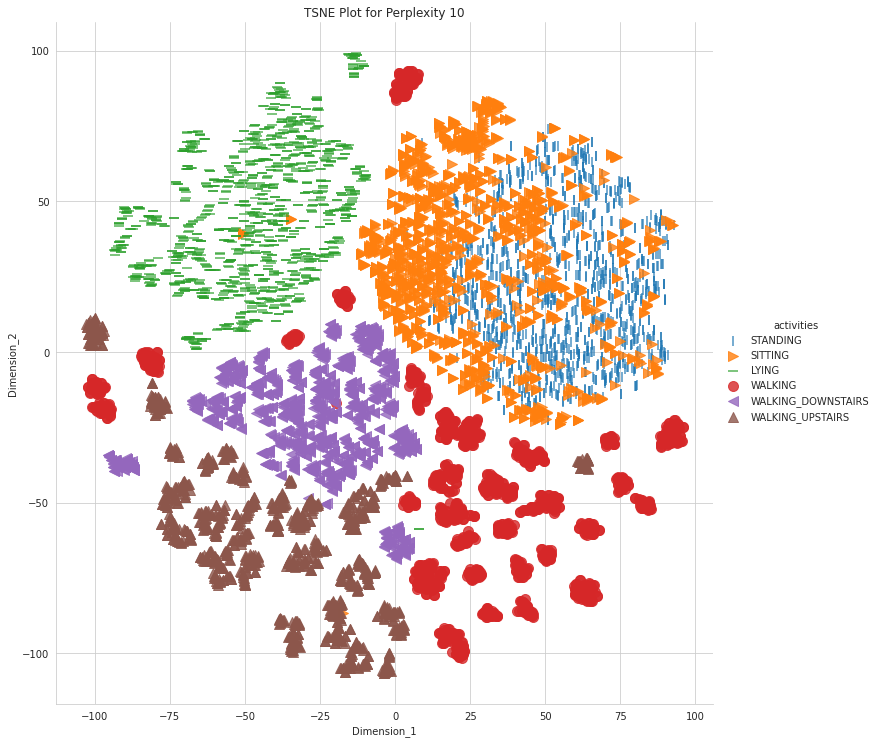

*******/*/*/*/**********  DONE BY MAHESH */*/*//////////*/*/************
Done...
Plotting TSNE Visualization...


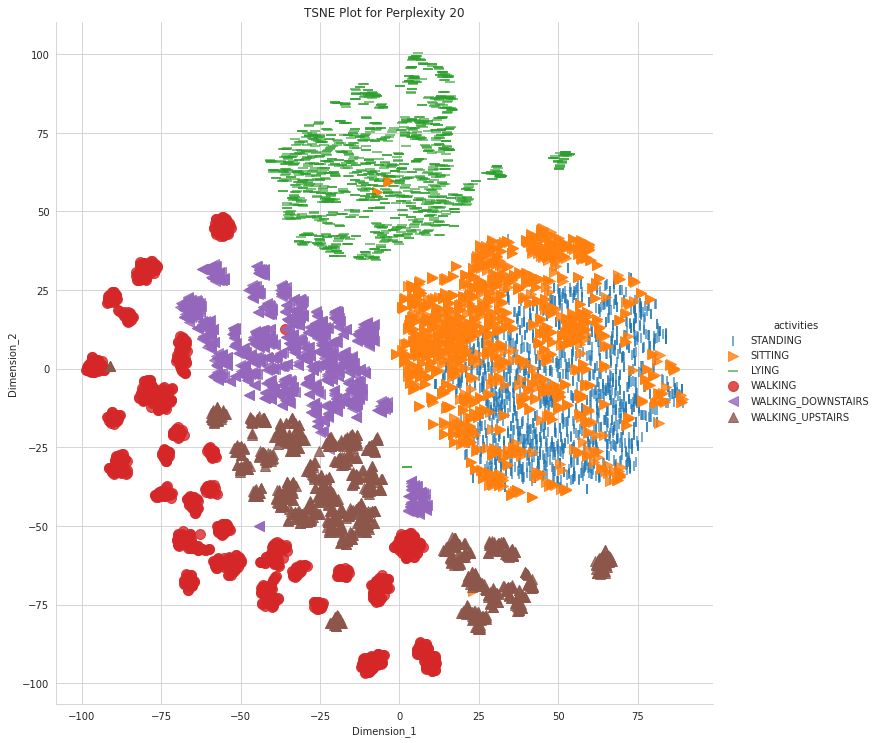

*******/*/*/*/**********  DONE BY MAHESH */*/*//////////*/*/************
Done...
Plotting TSNE Visualization...


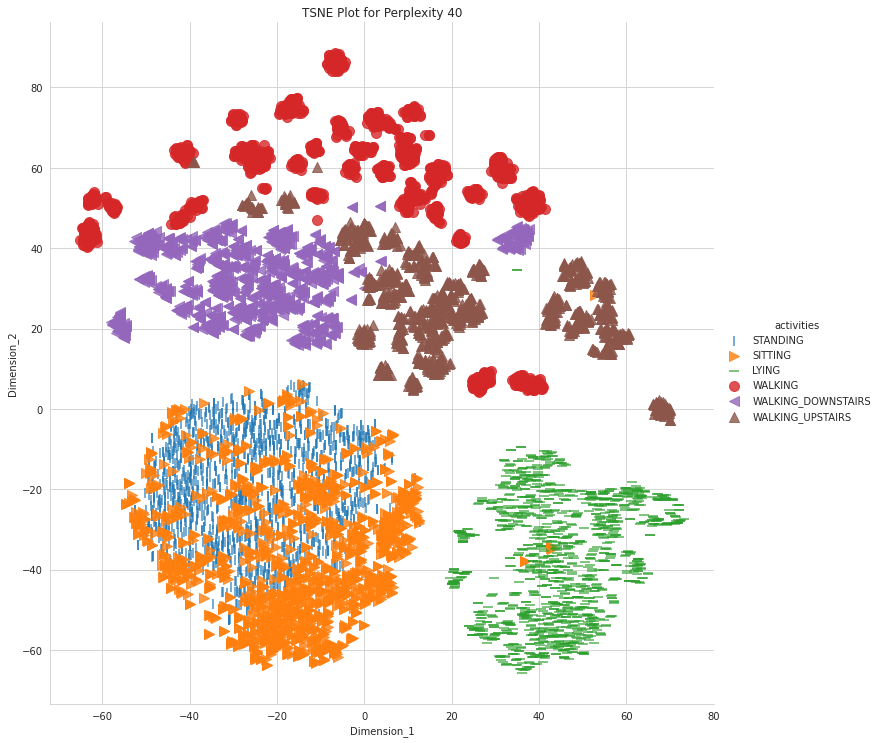

*******/*/*/*/**********  DONE BY MAHESH */*/*//////////*/*/************
Done...
Plotting TSNE Visualization...


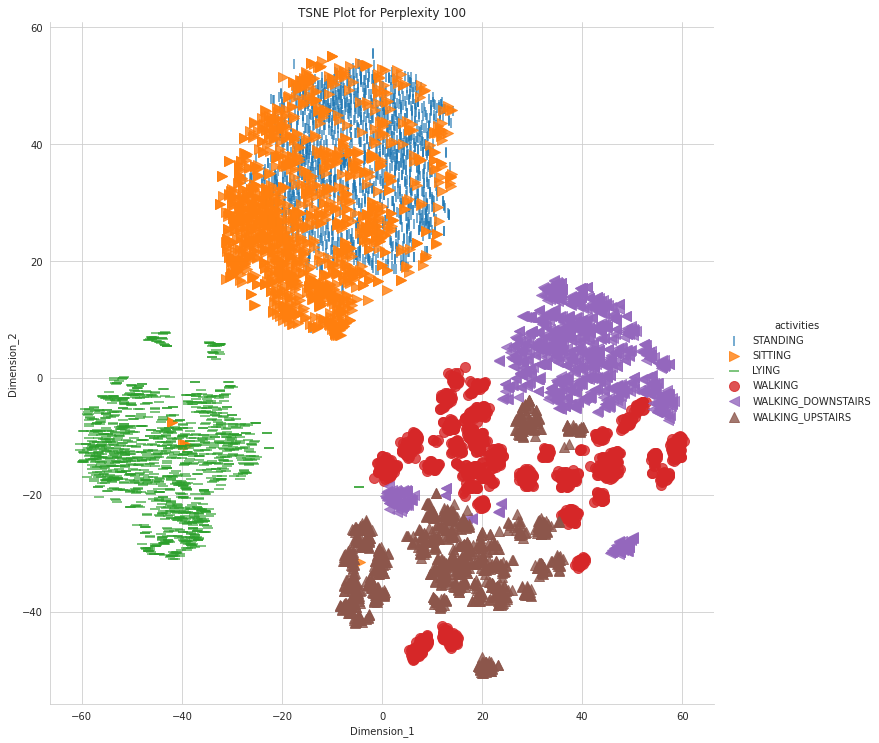

In [ ]:
perplexities = [5, 10, 20, 40, 100]
for perplexity in perplexities:
    plt_tsne(perplexity, train_df)


From above TSNE plots, we can observe that except <b>STANDING</b> and <b>SITTING</b>, all other activities are separated fairly well.

## 8. Machine Learning Models

In [ ]:
x_train = train_df.drop(["subject_id", "activity", "activity_name"], axis = 1)
y_train = train_df["activity"]

x_test = test_df.drop(["subject_id", "activity", "activity_name"], axis = 1)
y_test = test_df["activity"]

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((7352, 561), (7352,), (2947, 561), (2947,))

In [ ]:
table = pd.DataFrame(columns = ["Model", "Accuracy(%)"])
def keeping_record(model_name, accuracy):
    global table
    table = table.append(pd.DataFrame([[model_name, accuracy]], columns = ["Model", "Accuracy(%)"]))
    table.reset_index(drop = True, inplace = True)

In [ ]:
def print_confusionMatrix(Y_TestLabels, PredictedLabels):
    confusionMatx = confusion_matrix(Y_TestLabels, PredictedLabels)
    
    precision = confusionMatx/confusionMatx.sum(axis = 0)
    
    recall = (confusionMatx.T/confusionMatx.sum(axis = 1)).T
    
    sns.set(font_scale=1.5)
    
    labels = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LYING"]
    
    plt.figure(figsize=(16,7))
    sns.heatmap(confusionMatx, cmap = "Blues", annot = True, fmt = ".1f", xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix", fontsize = 30)
    plt.xlabel('Predicted Class', fontsize = 20)
    plt.ylabel('Original Class', fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.xticks(rotation = 90)
    plt.show()
    
    print("❤️"*60)
    
    plt.figure(figsize=(16,7))
    sns.heatmap(precision, cmap = "cubehelix", annot = True, fmt = ".2f", xticklabels=labels, yticklabels=labels)
    plt.title("Precision Matrix", fontsize = 30)
    plt.xlabel('Predicted Class', fontsize = 20)
    plt.ylabel('Original Class', fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.xticks(rotation = 90)
    plt.show()
    
    print("🥀"*60)
    
    plt.figure(figsize=(16,7))
    sns.heatmap(recall, cmap = "gist_stern", annot = True, fmt = ".2f", xticklabels=labels, yticklabels=labels)
    plt.title("Recall Matrix", fontsize = 30)
    plt.xlabel('Predicted Class', fontsize = 20)
    plt.ylabel('Original Class', fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.xticks(rotation = 90)
    plt.show()

    print('🏋️'*60)

In [ ]:
def apply_model(cross_val, x_train, y_train, x_test, y_test, model_name):
    start = datetime.now()
    cross_val.fit(x_train, y_train)
    predicted_points = cross_val.predict(x_test)
    
    print("Total time taken for tuning hyperparameter and making prediction by the model is (HH:MM:SS): {}\n".format(datetime.now() - start))
    accuracy = np.round(accuracy_score(y_test, predicted_points)*100, 2)
    
    print('---------------------')
    print('|      Accuracy (🎯)     |')
    print('---------------------')
    print(str(accuracy)+"%\n",'\n\n\n')
    
    print('---------------------------')
    print('|      Best Estimator (😬)     |')
    print('---------------------------')
    print("{}\n".format(cross_val.best_estimator_),'\n\n\n')
    
    print('----------------------------------')
    print('|      Best Hyper-Parameters (⚖️)     |')
    print('----------------------------------','\n\n\n')
    print(cross_val.best_params_)
    
    keeping_record(model_name, accuracy)
    
    print("\n\n")
    
    print_confusionMatrix(y_test, predicted_points)

## 8.1 Logistic Regression

Total time taken for tuning hyperparameter and making prediction by the model is (HH:MM:SS): 0:00:43.975770

---------------------
|      Accuracy (🎯)     |
---------------------
96.37%
 



---------------------------
|      Best Estimator (😬)     |
---------------------------
LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
 



----------------------------------
|      Best Hyper-Parameters (⚖️)     |
---------------------------------- 



{'C': 100, 'penalty': 'l2'}





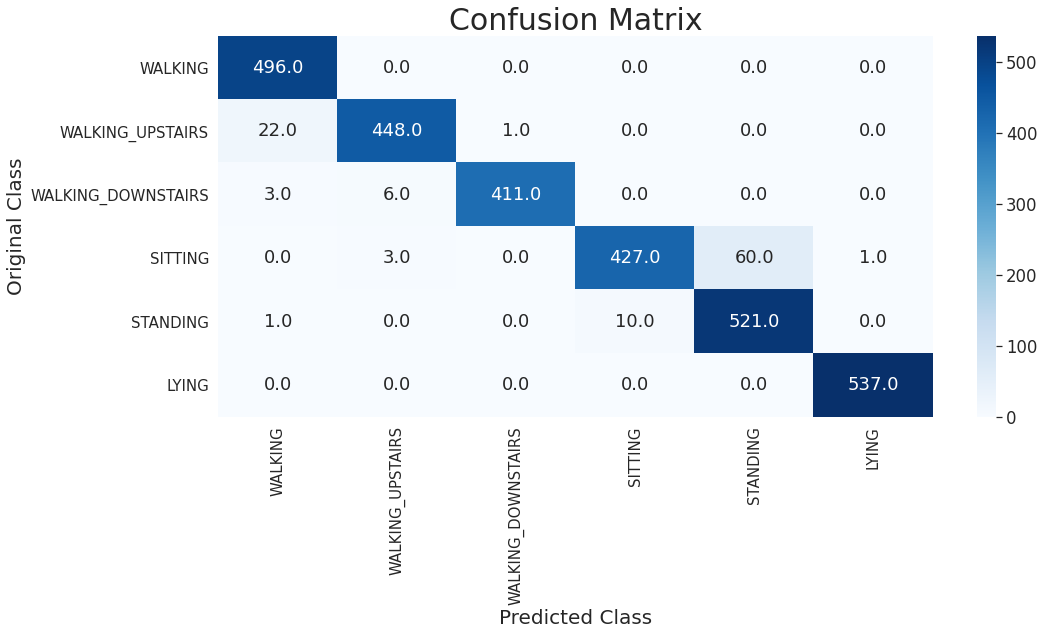

❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️


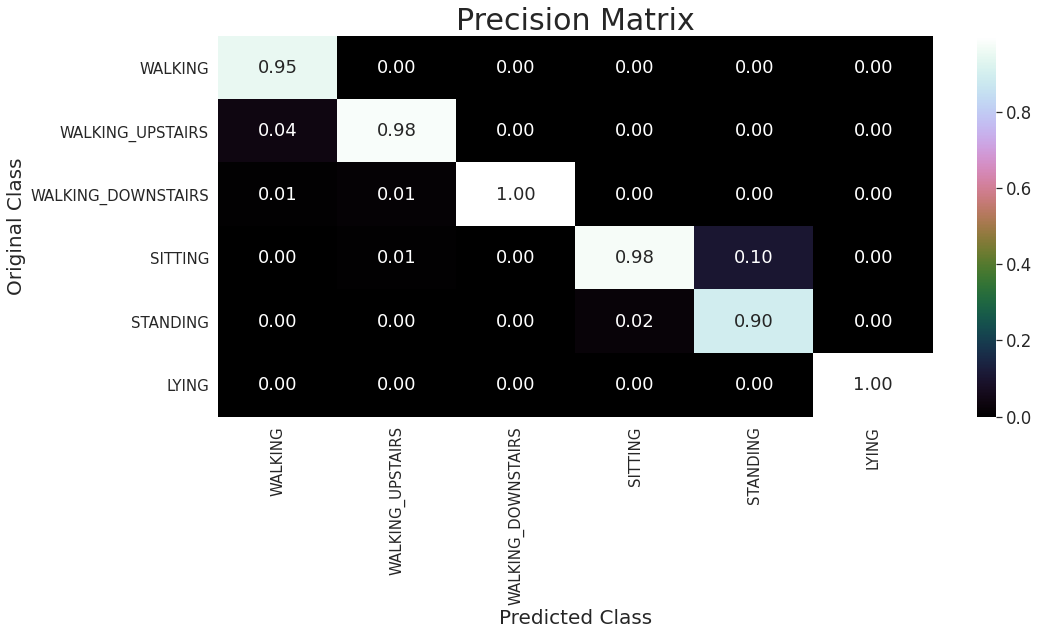

🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀


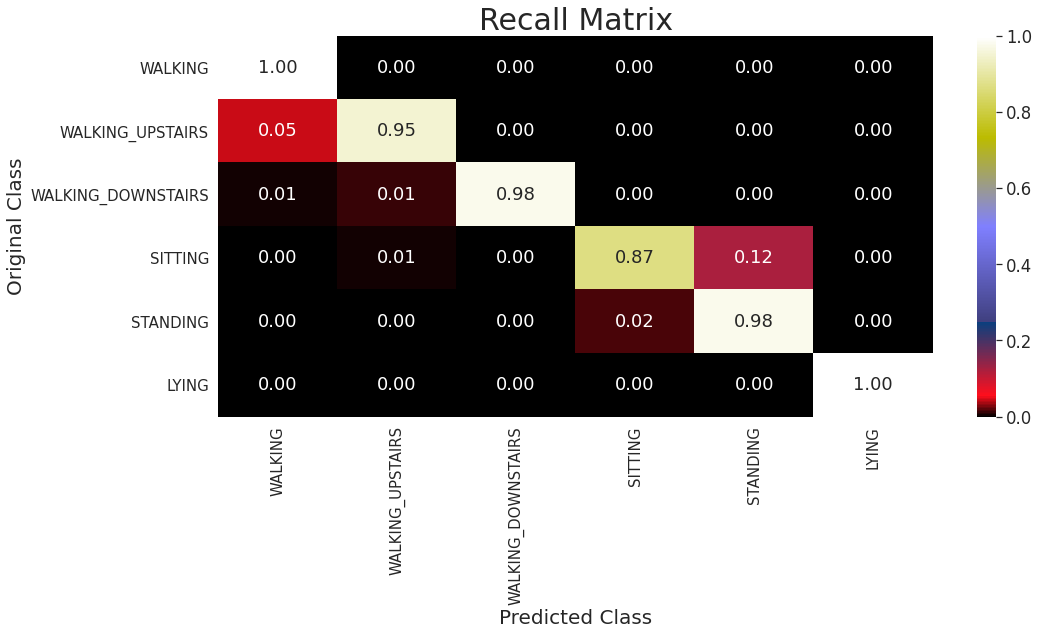

🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️


In [ ]:
parameters = {"C": [0.001, 0.01, 0.1, 1, 10**1, 10**2, 10**3], "penalty": ["l1", "l2"]}
clf = LogisticRegression(multi_class = "ovr")
cross_val = GridSearchCV(clf, parameters, cv=3)
apply_model(cross_val, x_train, y_train, x_test, y_test, "Logistic Regression")

## 8.2 Linear SVM

Total time taken for tuning hyperparameter and making prediction by the model is (HH:MM:SS): 0:00:59.137665

---------------------
|      Accuracy (🎯)     |
---------------------
96.4%
 



---------------------------
|      Best Estimator (😬)     |
---------------------------
LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
 



----------------------------------
|      Best Hyper-Parameters (⚖️)     |
---------------------------------- 



{'C': 1}





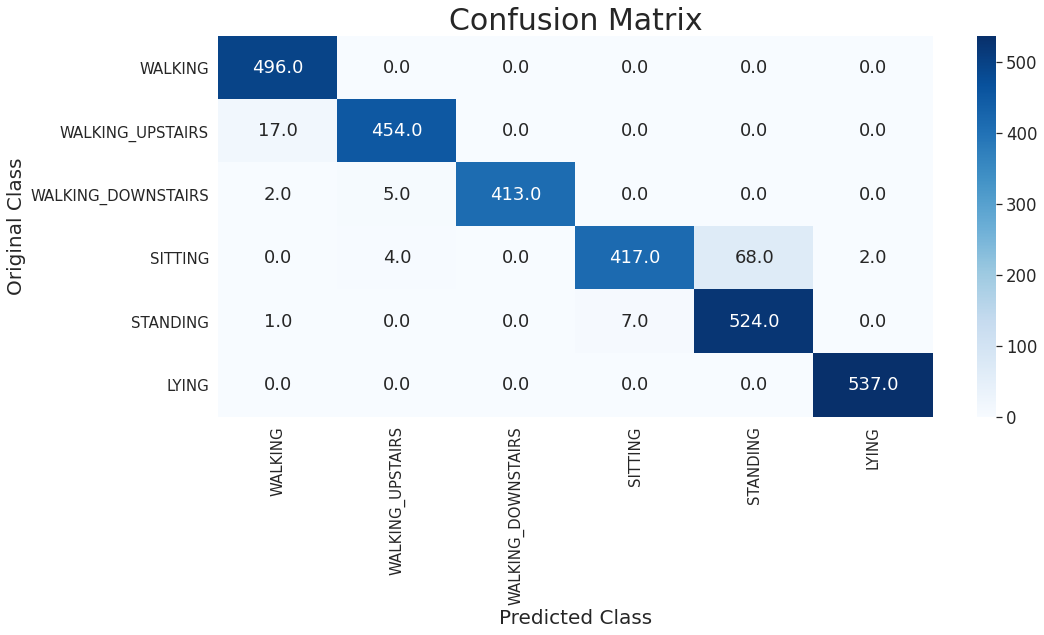

❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️


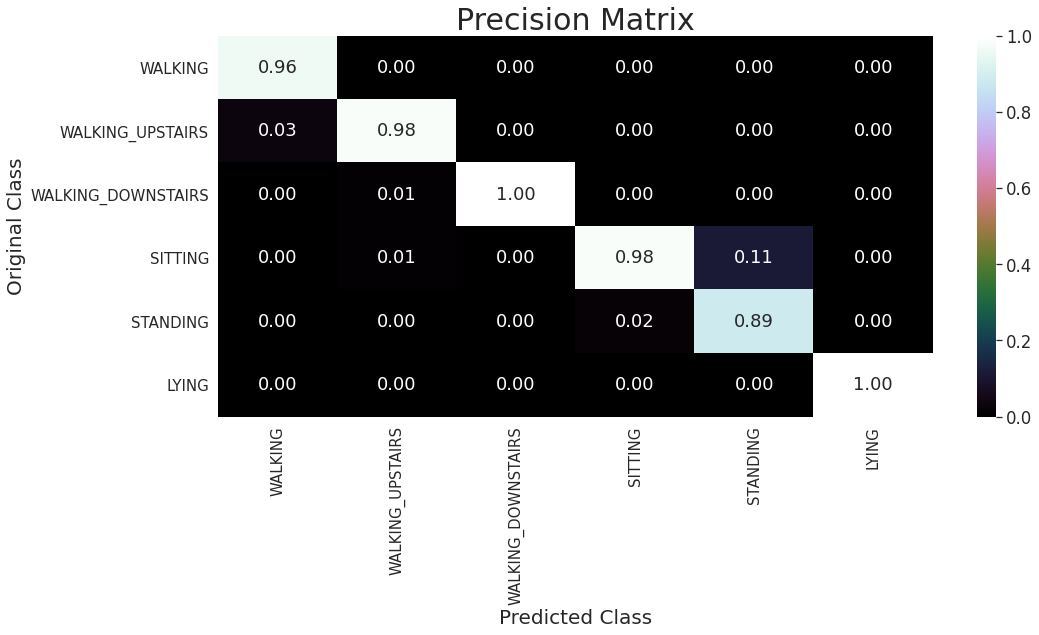

🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀


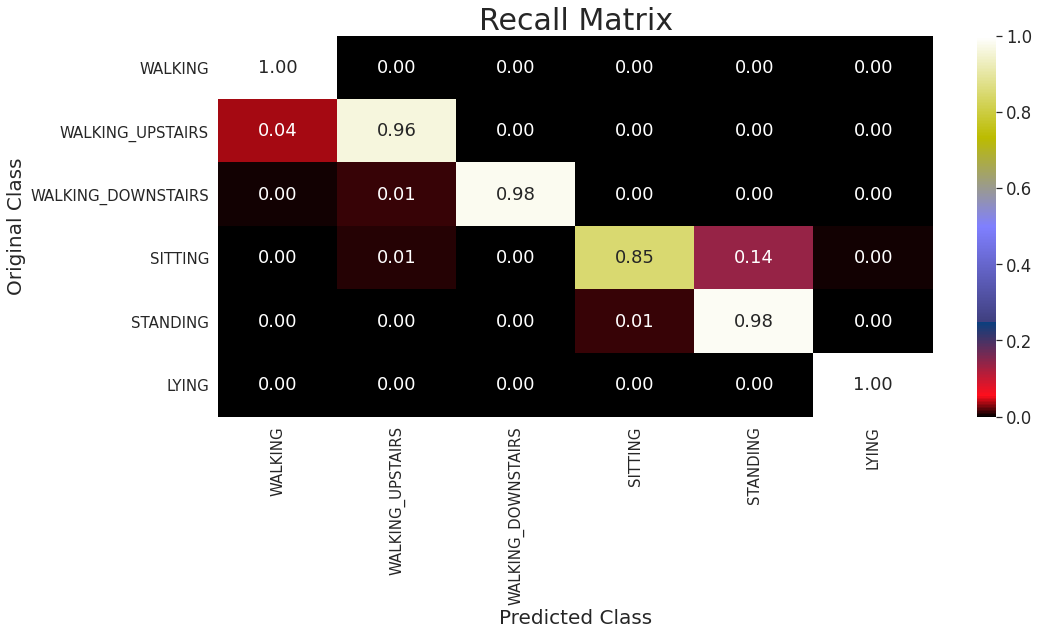

🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️


In [ ]:
parameters = {"C": [0.001, 0.01, 0.1, 1, 10**1, 10**2, 10**3]}
clf = LinearSVC()
cross_val = GridSearchCV(clf, parameters, cv=3)
apply_model(cross_val, x_train, y_train, x_test, y_test, "Linear SVM")

## 8.3 RBF SVM

Total time taken for tuning hyperparameter and making prediction by the model is (HH:MM:SS): 0:05:39.907079

---------------------
|      Accuracy (🎯)     |
---------------------
96.54%
 



---------------------------
|      Best Estimator (😬)     |
---------------------------
SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
 



----------------------------------
|      Best Hyper-Parameters (⚖️)     |
---------------------------------- 



{'C': 100}





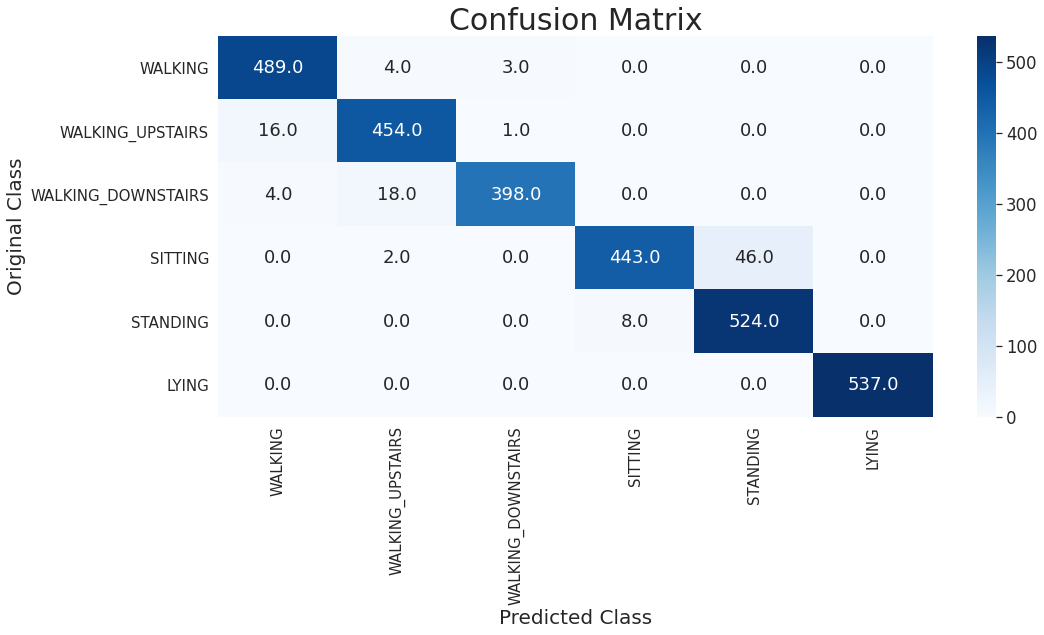

❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️


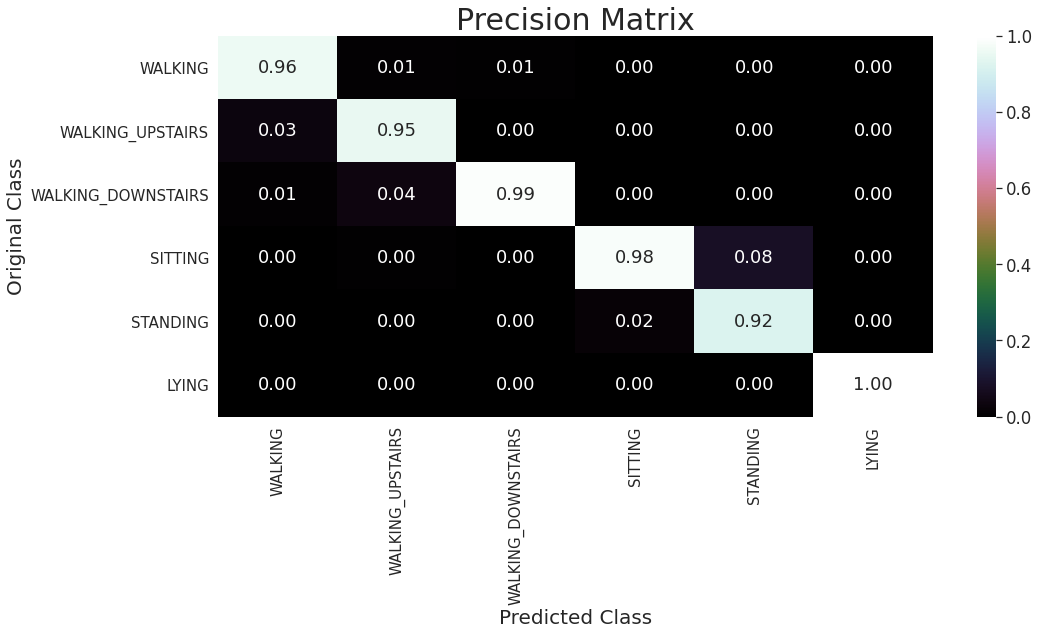

🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀


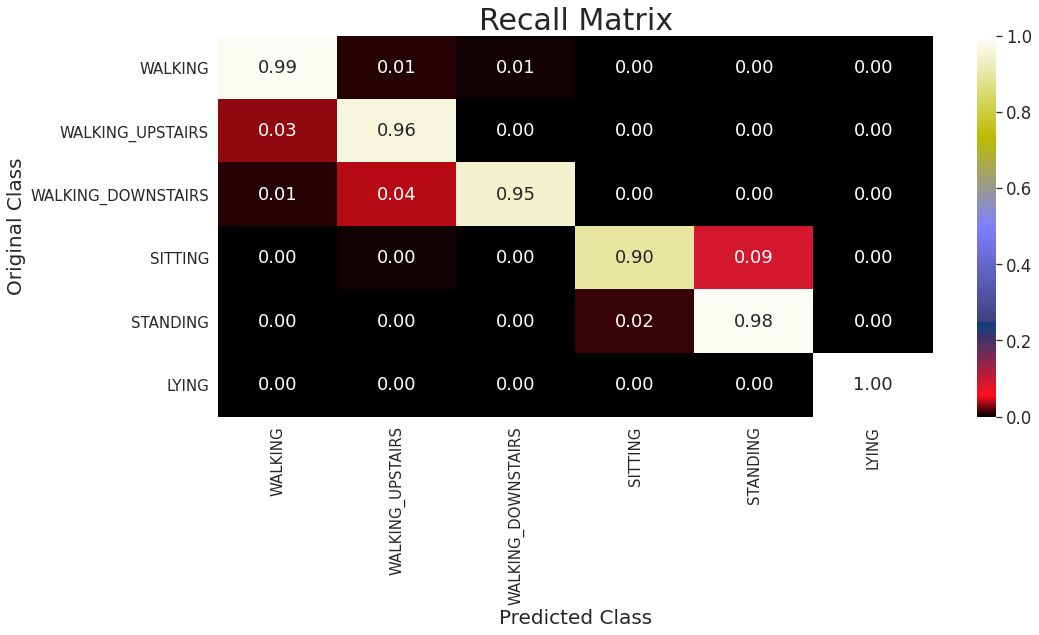

🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️


In [ ]:
parameters = {"C": [0.001, 0.01, 0.1, 1, 10**1, 10**2, 10**3]}
clf = SVC()
cross_val = GridSearchCV(clf, parameters, cv=3)
apply_model(cross_val, x_train, y_train, x_test, y_test, "RBF SVM")

## 8.4 Decision Trees

Total time taken for tuning hyperparameter and making prediction by the model is (HH:MM:SS): 0:00:31.315044

---------------------
|      Accuracy (🎯)     |
---------------------
85.44%
 



---------------------------
|      Best Estimator (😬)     |
---------------------------
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
 



----------------------------------
|      Best Hyper-Parameters (⚖️)     |
---------------------------------- 



{'max_depth': 6}





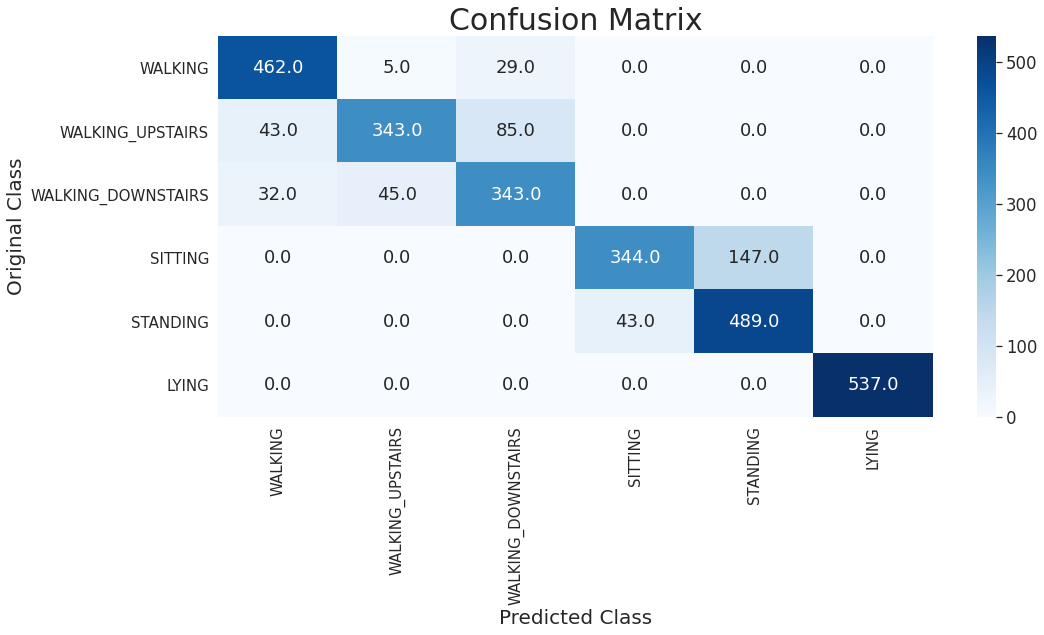

❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️


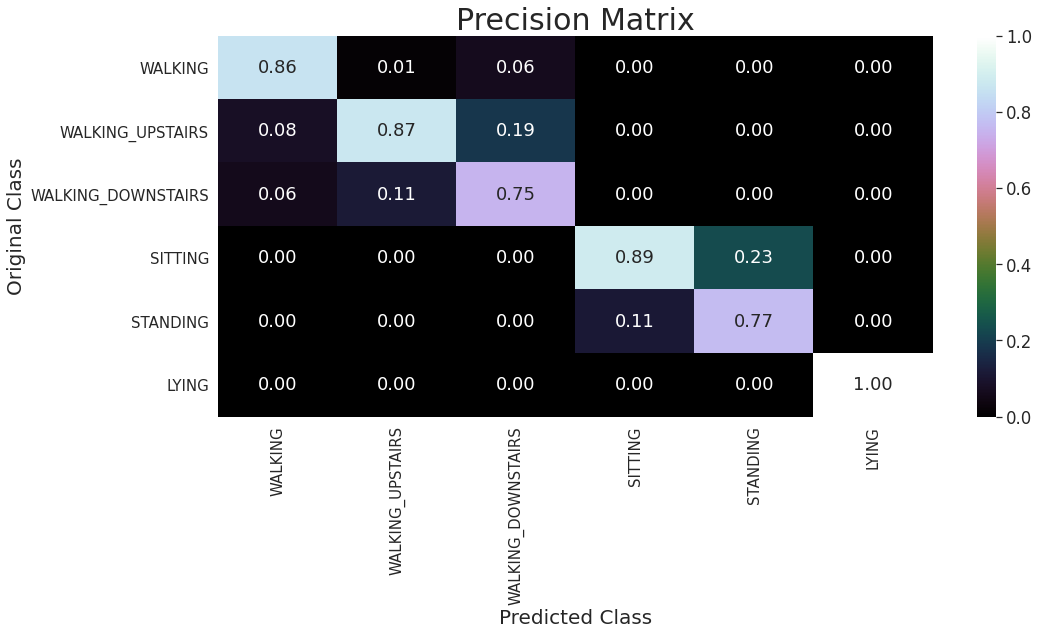

🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀


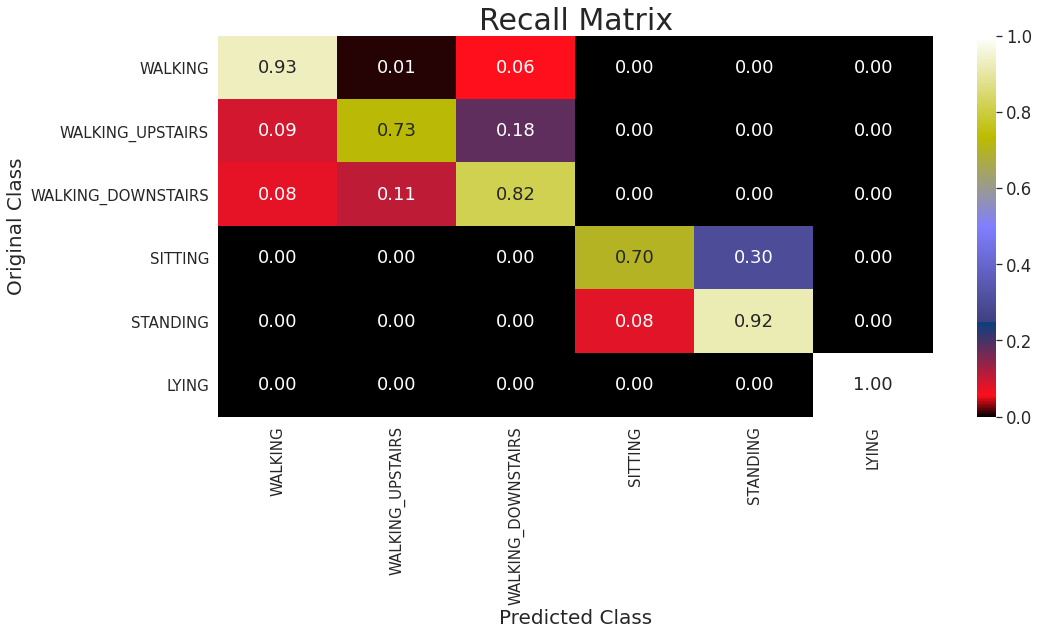

🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️


In [ ]:
parameters = {"max_depth": [2, 3, 4, 5, 6, 7, 8]}
clf = DecisionTreeClassifier()
cross_val = GridSearchCV(clf, parameters, cv=3)
apply_model(cross_val, x_train, y_train, x_test, y_test, "Decision Trees")

## 8.5 Random Forest

Total time taken for tuning hyperparameter and making prediction by the model is (HH:MM:SS): 0:05:45.533502

---------------------
|      Accuracy (🎯)     |
---------------------
92.06%
 



---------------------------
|      Best Estimator (😬)     |
---------------------------
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
 



----------------------------------
|      Best Hyper-Parameters (⚖️)     |
---------------------------------- 



{'n_estimators': 50}





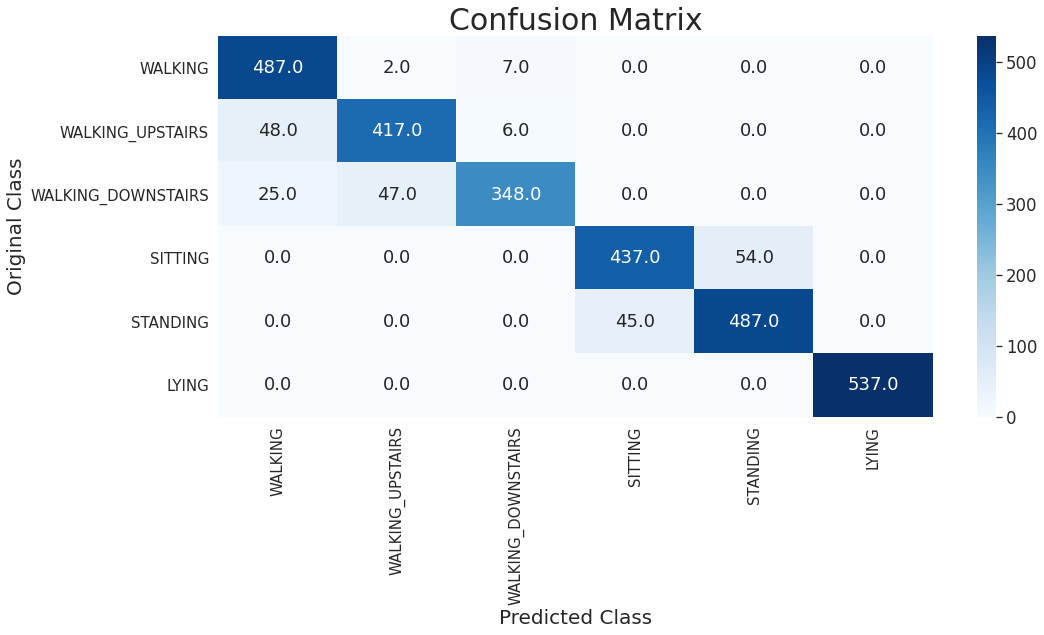

❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️


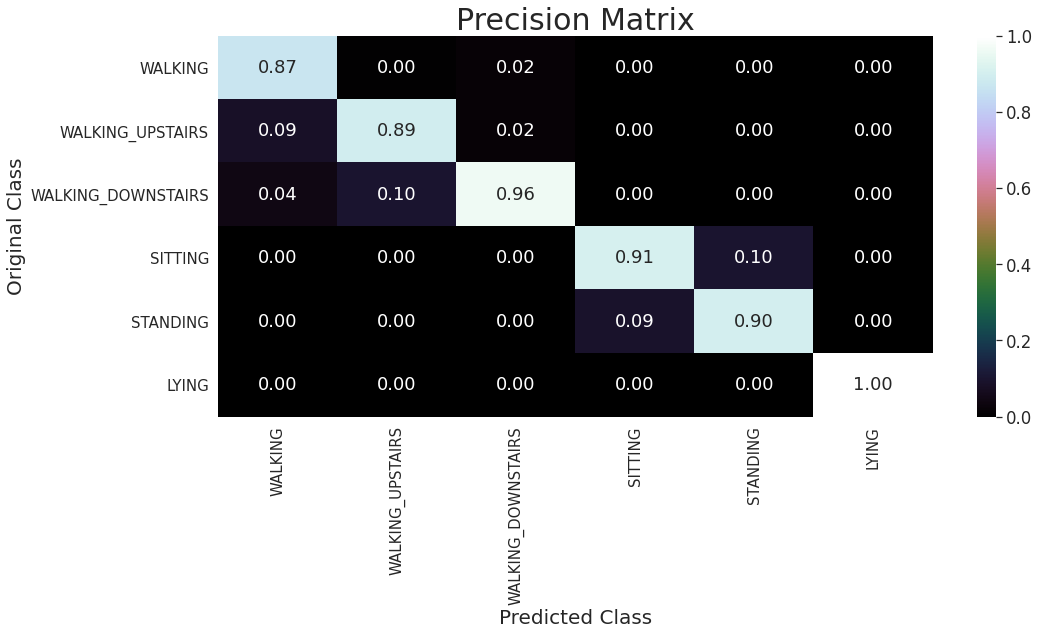

🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀


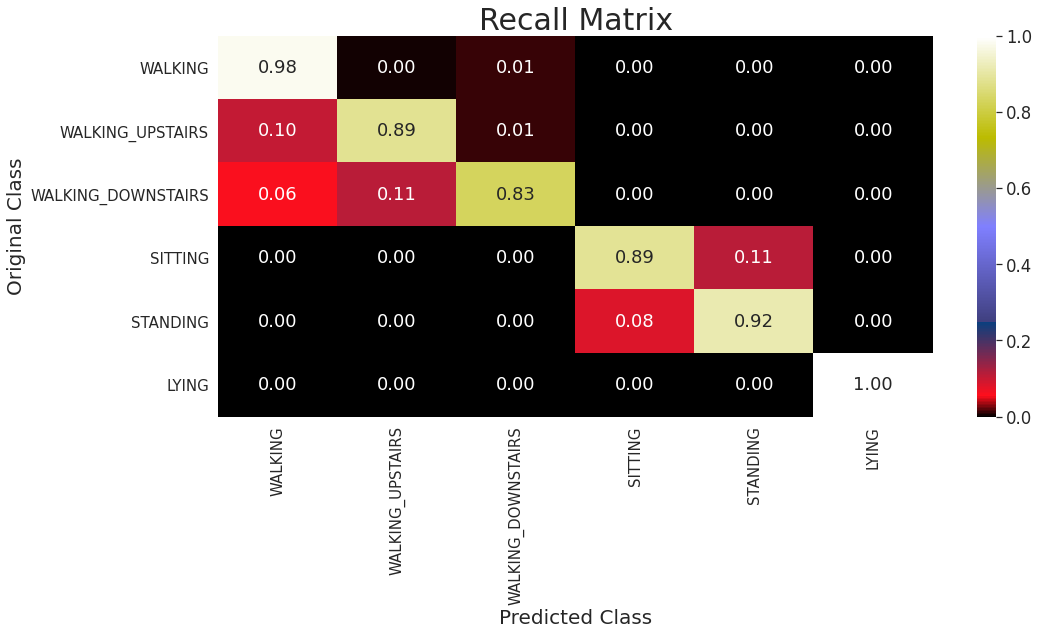

🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️


In [ ]:
parameters = {"n_estimators": [50, 100, 200, 400, 800]}
clf = RandomForestClassifier()
cross_val = GridSearchCV(clf, parameters, cv=3)
apply_model(cross_val, x_train, y_train, x_test, y_test, "Random Forest")

## 9. Model Comparison

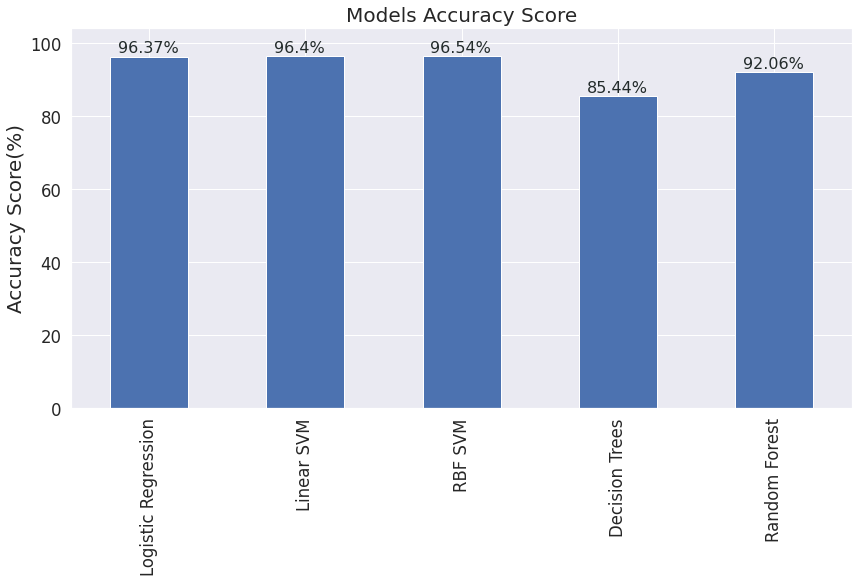

In [ ]:
ax = table.plot(x = "Model", y = "Accuracy(%)", kind = "bar", figsize = (14, 7), legend = False)
plt.title("Models Accuracy Score", fontsize = 20)
plt.xlabel("")
plt.margins(x = 0, y = 0.08)
plt.ylabel("Accuracy Score(%)", fontsize = 20)
plt.grid(visible = True)
for i in ax.patches:
    ax.text(x = i.get_x()+0.05, y = i.get_height()+1, s = str(i.get_height())+"%", fontsize = 16, color = "#232b2b")

In [ ]:
table

,Model,Accuracy(%)
0,Logistic Regression,96.37
1,Linear SVM,96.40
2,RBF SVM,96.54
3,Decision Trees,85.44
4,Random Forest,92.06


## 10. Applying Deep Learning Model: LSTM

<b>Here in LSTM, we will use 128 sized raw readings that we obtained from accelerometer and gyroscope signals.</b>

### 10.1 Reading Data

In [ ]:
all_signals_list = ["body_acc_x_", "body_acc_y_", "body_acc_z_", "body_gyro_x_", "body_gyro_y_", "body_gyro_z_", 
                   "total_acc_x_", "total_acc_y_", "total_acc_z_"]

In [ ]:
def reading_data(filename):
    return pd.read_csv(filename, delim_whitespace = True, header = None)

In [ ]:
def total_signal_matrix(trainOrTest):
    complete_data = []
    for signal in all_signals_list:
        complete_data.append(reading_data("/content/UCI HAR Dataset/"+ trainOrTest +"/Inertial Signals/"+ signal + trainOrTest +".txt").to_numpy())
    return np.transpose(complete_data, (1, 2, 0))

In [ ]:
def load_labels(subset):
    filename = "/content/UCI HAR Dataset/"+subset+"/y_"+subset+".txt"
    y = reading_data(filename)
    return pd.get_dummies(y[0]).to_numpy()


In [ ]:
def load_full_data():
    x_train = total_signal_matrix("train")
    y_train = load_labels("train")
    x_test = total_signal_matrix("test")
    y_test = load_labels("test")
    return x_train, y_train, x_test, y_test

In [ ]:
x_train, y_train, x_test, y_test = load_full_data()
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((7352, 128, 9), (7352, 6), (2947, 128, 9), (2947, 6))

In [ ]:
#saving data for loading it later in hyperas for hyper-parameter tuning
np.save("/content/UCI HAR Dataset/train", x_train)
np.save("/content/UCI HAR Dataset/train_label", y_train)
np.save("/content/UCI HAR Dataset/test", x_test)
np.save("/content/UCI HAR Dataset/test_label", y_test)

In [ ]:
def data():
    x_train = np.load("/content/UCI HAR Dataset/train.npy")
    y_train = np.load("/content/UCI HAR Dataset/train_label.npy")
    x_test = np.load("/content/UCI HAR Dataset/test.npy")
    y_test = np.load("/content/UCI HAR Dataset/test_label.npy")
    return x_train, y_train, x_test, y_test

In [ ]:

def count_unique_classes(y_train):
    return len(set([tuple(a) for a in y_train]))

### 10.2 Hyper-Parameter Tuning with Hyperas and Applying LSTM with best Hyper-Parameters

In [ ]:
def create_model(x_train, y_train, x_test, y_test):
    
    epochs = 8
    batch_size = 32
    timesteps = x_train.shape[1]
    input_dim = len(x_train[0][0])
    n_classes = 6
    
    model = Sequential()
    
    model.add(LSTM(64, return_sequences = True, input_shape = (timesteps, input_dim)))
    model.add(Dropout({{uniform(0, 1)}}))
    
    model.add(LSTM({{choice([32, 16])}}))
    model.add(Dropout({{uniform(0, 1)}}))
    
    model.add(Dense(n_classes, activation='sigmoid'))
    
    print(model.summary())
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='rmsprop')
    
    result = model.fit(x_train, y_train, batch_size = batch_size, epochs=epochs, verbose=2, validation_split=0.01)
    
    validation_acc = np.amax(result.history['val_accuracy']) 
    
    print('Best validation acc of epoch:', validation_acc)
    
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}

>>> Imports:
#coding=utf-8

try:
    import numpy as np
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import seaborn as sns
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    from sklearn.manifold import TSNE
except:
    pass

try:
    import warnings
except:
    pass

try:
    from datetime import datetime
except:
    pass

try:
    from sklearn.model_selection import GridSearchCV
except:
    pass

try:
    from sklearn.metrics import confusion_matrix
except:
    pass

try:
    from sklearn.metrics import accuracy_score
except:
    pass

try:
    from sklearn.linear_model import LogisticRegression
except:
    pass

try:
    from sklearn.svm import LinearSVC
except:
    pass

try:
    from sklearn.svm import SVC
except:
    pass

try:
    from sklearn.tree import DecisionTreeClassifier
except:
    pass

try:
    from sklearn.ensemble import RandomForestClassifier
except:
    pass

try:
    from sklearn.ensemble import Gradi

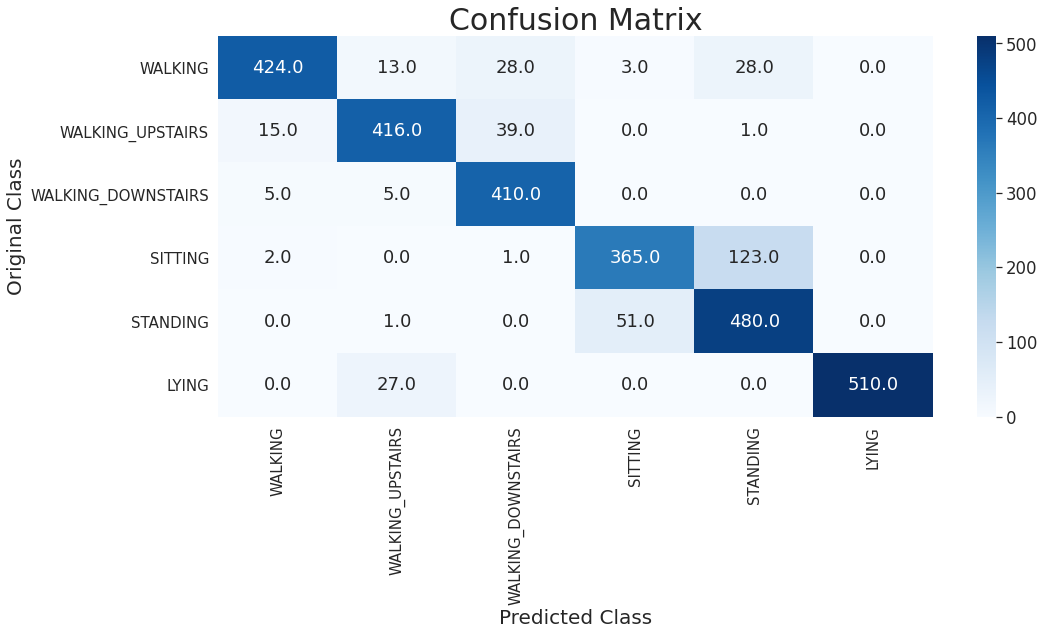

❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️❤️


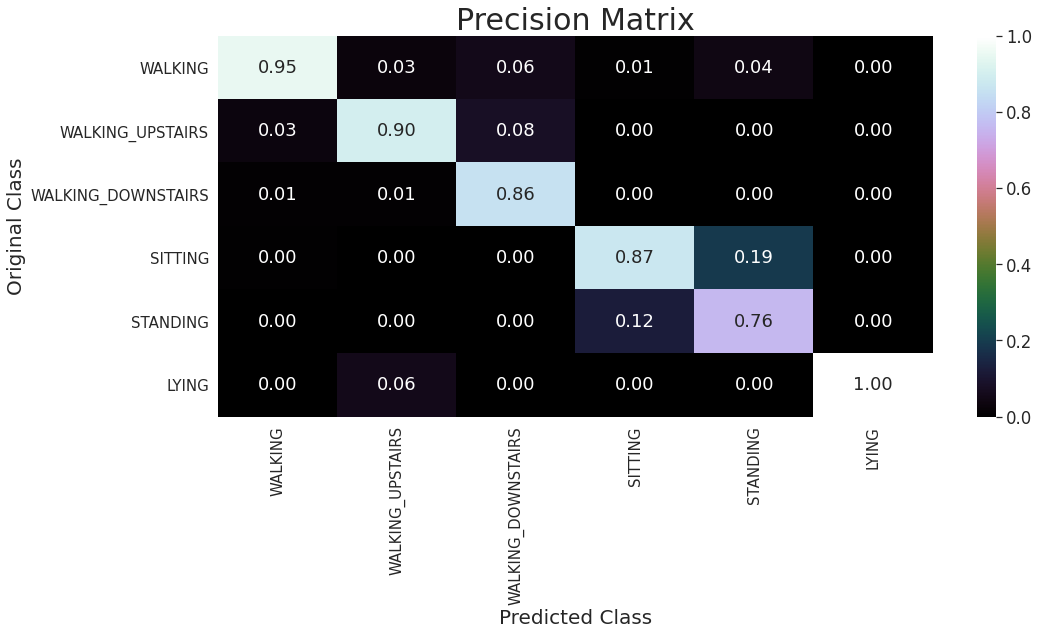

🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀🥀


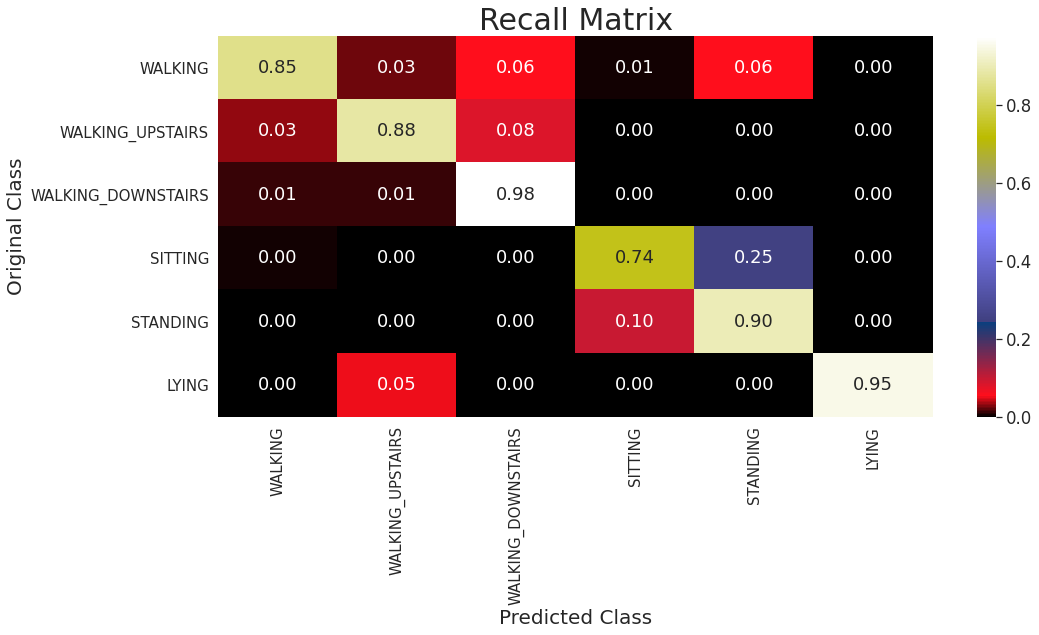

🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️


In [ ]:
best_run, best_model = optim.minimize(model=create_model, data=data, algo=tpe.suggest, max_evals=4, trials=Trials(), notebook_name = "casestudy2")
x_train, y_train, x_test, y_test = data()

score = best_model.evaluate(x_test, y_test)

print('---------------------')
print('|      Accuracy      |')
print('---------------------')
acc = np.round((score[1]*100), 2)
print(str(acc)+"%\n")
    
print('----------------------------------')
print('|      Best Hyper-Parameters      |')
print('----------------------------------')
print(best_run)
print("\n\n")

true_labels = [np.argmax(i)+1 for i in y_test]
predicted_probs = best_model.predict(x_test)
predicted_labels = [np.argmax(i)+1 for i in predicted_probs]
print_confusionMatrix(true_labels, predicted_labels)